In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.io import loadmat
import pandas as pd
import h5py
import seaborn as sns

import pyTMD

r2d = 180/np.pi

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [2]:
root_dir='/Users/zcaspar/codes/mit4320/'
fig_dir='/Users/zcaspar/Documents/Figure_Nature/'
import matplotlib as mpl
mpl.rcParams["font.size"] = 15

In [3]:
def load_matfiles(file, variables,model_name='HYCOM'):
    ds = loadmat(root_dir+file)
    lat = ds['IntegralQuantities_BinAverages_'+model_name]['targetgrid_lats'][0][0]
    lon = ds['IntegralQuantities_BinAverages_'+model_name]['targetgrid_lons'][0][0]
    data = {v:(['lon_bin','lat_bin'],ds['IntegralQuantities_BinAverages_'+model_name][v][0][0]) for v in variables}
    data['lat_bin'] = (['lat_bin'],lat.flatten())
    data['lon_bin'] = (['lon_bin'],lon.flatten())
    ds_out = xr.Dataset(data)
    ds_out.coords['lon_bin'] = (ds_out.coords['lon_bin'] + 180) % 360 - 180
    ds_out = ds_out.sortby(ds_out.lon_bin)
    return ds_out

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,lat='lat_bin',**kwargs):
    """
    Plot maps of a given xarray.
    ----------------------------------------------
    Parameters:
    ds : xarray, 2D variable
    colmap : colormap to use in the plot (see list of colormaps on matplotlib), default is 'RdBu_r'
    vlim : tuple, limits of the colorbar (vmin, vmax)
    axes : subplots definition, default is one figure (111)
    lat : str, name of the latitude axis, default is 'lat_bin'
    kwargs : dict, properties of the colorbar (example: {'orientation':'horizontal'})
    """
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    cbar_kwargs = {'fraction':0.02}
    cbar_kwargs.update(**kwargs)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y=lat,ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,#**kwargs,
            cbar_kwargs=cbar_kwargs) #{'fraction':0.02,'label':'energy'}
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    return fig,ax

In [5]:
HYCOM_variables = ['HYCOM_0m_semidiurnal_wide_binavg','HYCOM_15m_semidiurnal_wide_binavg']
MITgcm_variables = ['MITgcm_0m_semidiurnal_wide_binavg','MITgcm_15m_semidiurnal_wide_binavg']

In [6]:
#Loading HYCOM files
ds_hycom = load_matfiles('HYCOM_binaverages_onedegreegrid.mat',HYCOM_variables)
ds_hycom = ds_hycom.rename({'HYCOM_0m_semidiurnal_wide_binavg':'energy_0m',
                              'HYCOM_15m_semidiurnal_wide_binavg':'energy_15m'})

In [7]:
#Loading MITgcm files
ds_mitgcm = load_matfiles('MITgcm_binaverages_onedegreegrid.mat',MITgcm_variables,model_name='MITgcm')
ds_mitgcm = ds_mitgcm.rename({'MITgcm_0m_semidiurnal_wide_binavg':'energy_0m',
                              'MITgcm_15m_semidiurnal_wide_binavg':'energy_15m'})

In [8]:
#Loading MITgcm spectra:
mitgcm_spectra = xr.Dataset({'lat_bin':(['lat_bin'],ds_mitgcm.lat_bin.values),
                             'lon_bin':(['lon_bin'],ds_mitgcm.lon_bin.values),
                             'freq' : (['freq'],24*np.arange(-720,720,1)*(1/(1440)))
                            })
for v in ['MITgcm_0m_fullspectra_binavg','MITgcm_15m_fullspectra_binavg']:
    mitgcm_spectra[v[:9]] = (['lat_bin','lon_bin','freq'],loadmat(root_dir+'binavg_MITgcm_fullspectra_onto_onedeg_grid.mat')[v])

                           

In [9]:
ds = h5py.File(root_dir+'drifters_semidiurnal_wide_ke.mat','r+')
#ds = loadmat(root_dir+'drifters_semidiurnal_wide_ke.mat')

In [10]:
array={}
array['lat_bin'] = (['lat_bin'], ds['drifters_semidiurnal_wide_ke']['drifters_semidiurnal_wide']['ymid'][0])
array['lon_bin'] = (['lon_bin'], ds['drifters_semidiurnal_wide_ke']['drifters_semidiurnal_wide']['xmid'][0])

In [11]:
energy_real = ds['drifters_semidiurnal_wide_ke']['drifters_semidiurnal_wide']['covz'][0,0,:,:]['real']+ds['drifters_semidiurnal_wide_ke']['drifters_semidiurnal_wide']['covz'][1,1,:,:]['real']
energy_imag = ds['drifters_semidiurnal_wide_ke']['drifters_semidiurnal_wide']['covz'][0,0,:,:]['imag']+ds['drifters_semidiurnal_wide_ke']['drifters_semidiurnal_wide']['covz'][1,1,:,:]['imag']

energy_real_d = ds['drifters_semidiurnal_wide_ke']['drifters_semidiurnal_wide_d']['covz'][0,0,:,:]['real']+ds['drifters_semidiurnal_wide_ke']['drifters_semidiurnal_wide_d']['covz'][1,1,:,:]['real']
energy_real_u = ds['drifters_semidiurnal_wide_ke']['drifters_semidiurnal_wide_u']['covz'][0,0,:,:]['real']+ds['drifters_semidiurnal_wide_ke']['drifters_semidiurnal_wide_u']['covz'][1,1,:,:]['real']

In [12]:
array['energy_real'] = (['lon_bin','lat_bin'],energy_real)
array['energy_imag'] = (['lon_bin','lat_bin'],energy_imag)

array['energy_real_d'] = (['lon_bin','lat_bin'],energy_real_d)
array['energy_real_u'] = (['lon_bin','lat_bin'],energy_real_u)

In [13]:
ds_GDP = xr.Dataset(array)
ds_GDP.coords['lon_bin'] = (ds_GDP.coords['lon_bin'] + 180) % 360 - 180
ds_GDP = ds_GDP.sortby(ds_GDP.lon_bin).sel(lat_bin=slice(-60,60))

In [14]:
ds_GDP = ds_GDP.where(ds_hycom.energy_0m>0)

In [15]:
#Loading Mitgcm files (mine):
ds_dl1 = xr.merge([xr.open_dataset(root_dir+'energy_SSU_hf_binned_dl1.0.nc'),
                   xr.open_dataset(root_dir+'energy_SSV_hf_binned_dl1.0.nc'),
                   xr.open_dataset(root_dir+'energy_hf_binned_dl1.0.nc')])
ds_hf = (0.5*ds_dl1).where(ds_dl1.waterdepth>500)
ds_hf = ds_hf.where(np.isnan(ds_hycom.energy_0m)==False)

ds_dl2 = xr.merge([xr.open_dataset(root_dir+'energy_SSU_hf_binned_dl2.0.nc'),
                   xr.open_dataset(root_dir+'energy_SSV_hf_binned_dl2.0.nc'),
#                   xr.open_dataset(root_dir+'energy_hf_binned_dl2.0.nc')
                  ])
ds_hf_dl2 = ds_dl2.where(ds_dl2.waterdepth>500)
ds_hf_dl2['E_energy'] = 0.5*(ds_hf_dl2['E_energy_SSU']+ds_hf_dl2['E_energy_SSV'])
ds_hf_dl2['L_energy'] = 0.5*(ds_hf_dl2['L_energy_SSU']+ds_hf_dl2['L_energy_SSV'])

In [16]:
#Loading Xiaolong energy levels:

dsL_yu = xr.open_dataset(root_dir+'L_SSUV.nc').SSUV_T60_band
dsE_yu = xr.open_dataset(root_dir+'E_SSUV.nc').SSUV_T60_band

dsE_yu = dsE_yu.rename({'lon_bins':'lon_bin','lat_bins':'lat_bin'})
dsL_yu = dsL_yu.rename({'lon_bins':'lon_bin','lat_bins':'lat_bin'})
dsL_yu = dsL_yu.where(np.isnan(ds_hycom.energy_0m)==False)
dsE_yu = dsE_yu.where(np.isnan(ds_hycom.energy_0m)==False)

In [17]:
#Loading GDP files
ds_gdp = xr.open_dataset(root_dir+'gdp_combined.nc')
ds_gdp = ds_gdp.rename({'lon':'lon_bin','lat':'lat_bin'})
ds_gdp['energy'] = (ds_gdp['semidiurnal_ve_abs2_mean']+ds_gdp['semidiurnal_vn_abs2_mean'])
ds_gdp = 2*ds_gdp.sel(lat_bin=slice(-60,60)).where(ds_gdp.h>500)

ds_gdp04 = xr.open_dataset(root_dir+'gdp_combined_b04.nc')
ds_gdp04 = ds_gdp04.rename({'lon':'lon_bin','lat':'lat_bin'})
ds_gdp04['energy'] = (ds_gdp04['semidiurnal_ve_abs2_mean']+ds_gdp04['semidiurnal_vn_abs2_mean'])
ds_gdp04 = ds_gdp04.sel(lat_bin=slice(-60,60))

In [19]:
# Loading theoretically predicted energy levels:
ds_predicted = xr.open_dataset(root_dir+'prediction_mode2.nc')
ds_predicted = ds_predicted.rename({'lon_bins':'lon_bin','lat_bins':'lat_bin'})
ds_predicted['energy_ratio'] = (ds_predicted['El']+ds_predicted['El_V'])/(ds_predicted['Ee']+ds_predicted['Ee_V'])

In [47]:
#HRET

constituents = ['2n2','eps2','j1','k1','k2','l2','lambda2','m2','m3','m4','m6',
            'm8','mf','mks2','mm','mn4','ms4','msf','msqm','mtm','mu2','n2',
            'n4','nu2','o1','p1','q1','r2','s1','s2','s4','sa','ssa','t2']

cpd = 86400/2/np.pi

def load_constituents(c=None):
    """
    Parameters
    ----------
    c: str, list
        constituent or list of constituent

    Returns
    -------
    amplitude: amplitude of equilibrium tide in m for tidal constituent
    phase: phase of tidal constituent
    omega: angular frequency of constituent in radians
    alpha: load love number of tidal constituent
    species: spherical harmonic dependence of quadrupole potential
    """
    if c is None:
        c = constituents
    if isinstance(c, list):
        df = (pd.DataFrame({_c: load_constituents(_c) for _c in c}).T)
        df = df.sort_values("omega")
        return df
    elif isinstance(c, str):
        p_names = ["amplitude", "phase", "omega", "alpha", "species"] 
        p = pyTMD.load_constituent(c)
        return pd.Series({_n: _p for _n, _p in zip(p_names, p)})
    
    
#c = load_constituents(constituents)
#c = load_constituents("m2")
c = load_constituents()

_c = c.loc[c.species==2.] # select semidiurnal constituents
_c = _c.sort_values("amplitude", ascending=False)

In [48]:
#Loading Ed Zaron files:
M2_stationary = xr.open_dataset(root_dir+'M2ke_2x2.nc')

M2_stationary = M2_stationary.rename({'lat_':'lat_bin','lon_':'lon_bin'})

M2_stationary = M2_stationary.sel(lat_bin=slice(-60,60))#.ke_.plot()
M2_stationary.coords['lon_bin'] = (M2_stationary.coords['lon_bin'] + 180) % 360 - 180
#M2_stationary['ke_'] = M2_stationary['ke_'].sortby('lon_bin')
_M2 = M2_stationary['ke_']
_M2 = _M2.sortby('lon_bin')
_M2 = _M2.where(_M2>0)

# Correction HRET
ds_hret = xr.Dataset({'energy_m2':_M2})

ds_hret["equilibirum_amplitude"] = _c["amplitude"]
ds_hret = ds_hret.rename({'dim_0':'species'})
ratio = (ds_hret['equilibirum_amplitude']).sum('species')/(ds_hret['equilibirum_amplitude'].sel(species='m2')**1)
ds_hret['energy_total'] = ratio*ds_hret.energy_m2
ds_hret = ds_hret.where(np.isnan(ds_gdp.L_energy)==False)
#ds_hret['energy_total'] = (ratio*ds_hret.energy_m2)

## Figure 1:

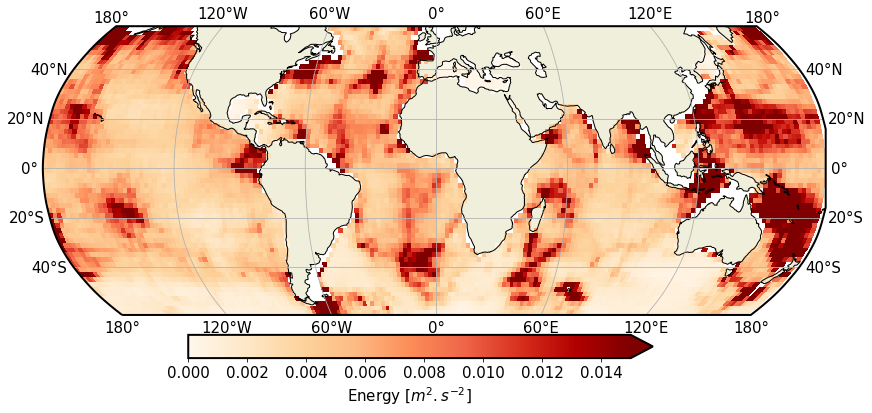

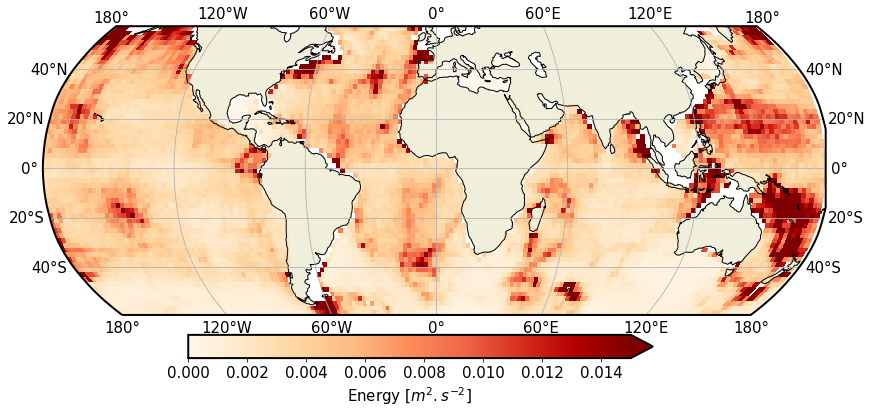

In [84]:
#Comparing filtering methods in mitgcm:
figsize = (15,6)
cmap = 'OrRd'
kwargs = {'orientation':'horizontal','pad':0.06,'fraction':0.07}
fig = plt.figure(figsize=figsize)
kwargs.update({'label':r'Energy [$m^2.s^{-2}$]'})
fig,ax = plot_maps(ds_hf_dl2.E_energy,colmap=cmap,vlim=(0,0.015),**kwargs)
ax.set_title(r'',size=15)
fig.tight_layout()
fig.savefig(fig_dir+'Eenergy_llc.png')

fig = plt.figure(figsize=figsize)
kwargs.update({'label':r'Energy [$m^2.s^{-2}$]'})
fig,ax = plot_maps(ds_hf_dl2.L_energy,colmap=cmap,vlim=(0,0.015),**kwargs)
ax.set_title(r'',size=15)
fig.tight_layout()
fig.savefig(fig_dir+'Lenergy_llc.png')

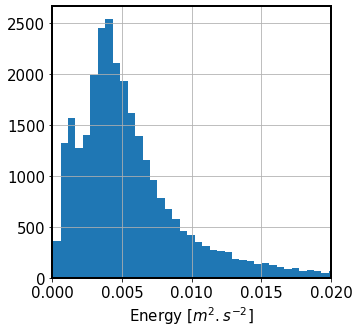

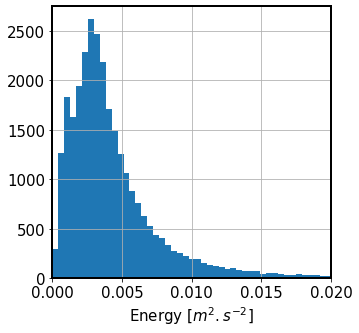

In [21]:
fig,ax = plt.subplots(figsize=(5,5))
_ = ds_hf.E_energy.plot.hist(ax=ax,bins=1000,xlim=(0,0.02))
ax.grid();ax.set_xlabel(r'Energy [$m^2.s^{-2}$]');
fig.savefig(fig_dir+'Eenergy_hist_llc.png')

fig,ax = plt.subplots(figsize=(5,5))
_ = ds_hf.L_energy.plot.hist(ax=ax,bins=1000,xlim=(0,0.02))
ax.grid();ax.set_xlabel(r'Energy [$m^2.s^{-2}$]');
fig.savefig(fig_dir+'Lenergy_hist_llc.png')

## Figure 2

In [22]:
ds_low_dl1 = xr.merge([xr.open_dataset(root_dir+'energy_SSU_low_binned_dl1.0.nc'),
                       xr.open_dataset(root_dir+'energy_SSV_low_binned_dl1.0.nc'),
                       xr.open_dataset(root_dir+'energy_low_binned_dl1.0.nc')])

ds_low_dl1 = ds_low_dl1.where(ds_low_dl1.waterdepth>500)

from scipy.ndimage.filters import gaussian_filter
ds_low_dl1['L_energy_smooth'] = (["lon_bin","lat_bin"],
                                 gaussian_filter(ds_low_dl1.L_energy.fillna(-1),sigma=[2,2],order=0,mode='constant'))
ds_low_dl1['L_energy_smooth'] = ds_low_dl1['L_energy_smooth'].where(ds_low_dl1['L_energy_smooth']>0)

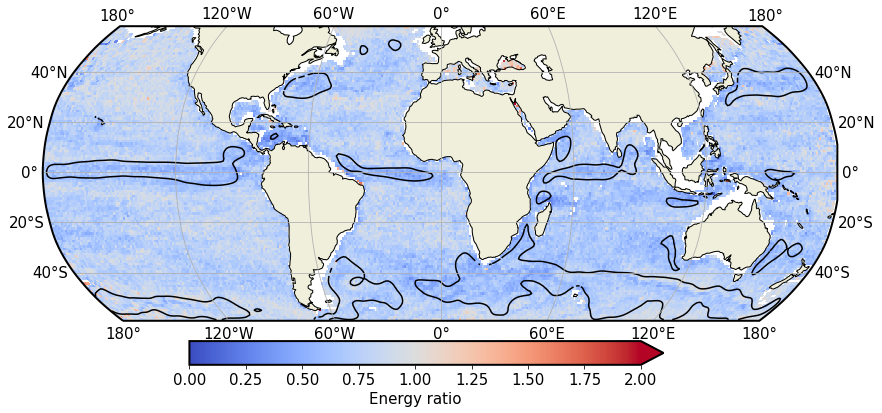

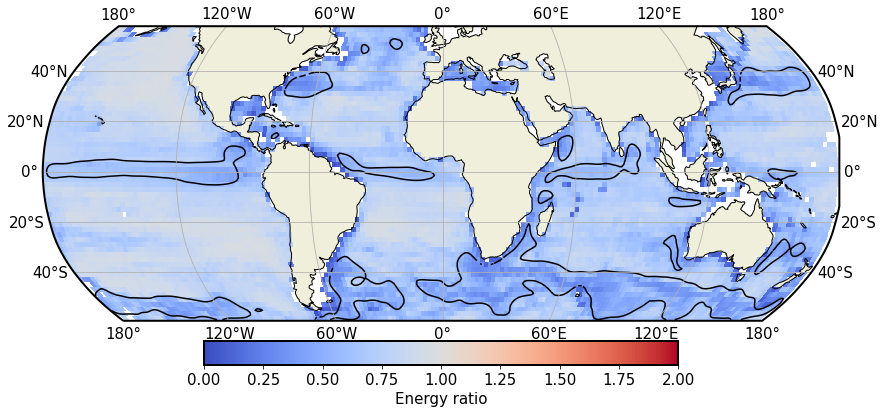

In [24]:
fig = plt.figure(figsize=figsize)
kwargs.update({'label': 'Energy ratio'})
fig,ax = plot_maps(ds_hf.L_energy/ds_hf.E_energy,colmap='coolwarm',vlim=(0.,2.),**kwargs)
(ds_low_dl1['L_energy_smooth']).plot.contour(ax=ax,transform=ccrs.PlateCarree(),
                                     y='lat_bin',levels=[0.1],colors=['black'])
#ax.set_title(r'$<\tilde{u}_L^2+\tilde{v}_L^2>_{t,b}/<[\tilde{u}_E^2+\tilde{v}_E^2]_t>_b$'
 #            ,size=15)
fig.tight_layout();
fig.savefig(fig_dir+'energy_ratio_llc.png')

fig = plt.figure(figsize=figsize)
kwargs.update({'label': 'Energy ratio'})
fig,ax = plot_maps(ds_predicted.energy_ratio,colmap='coolwarm',vlim=(0.,2.),**kwargs)
(ds_low_dl1['L_energy_smooth']).plot.contour(ax=ax,transform=ccrs.PlateCarree(),
                                     y='lat_bin',levels=[0.1],colors=['black'])
#ax.set_title(r'$<\tilde{u}_L^2+\tilde{v}_L^2>_{t,b}/<[\tilde{u}_E^2+\tilde{v}_E^2]_t>_b$'
 #            ,size=15)
fig.tight_layout();
fig.savefig(fig_dir+'energy_ratio_predicted_llc.png')

In [31]:
plot.set_axis_labels?

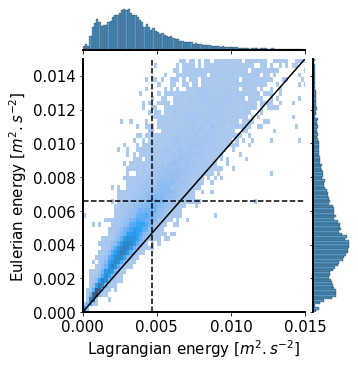

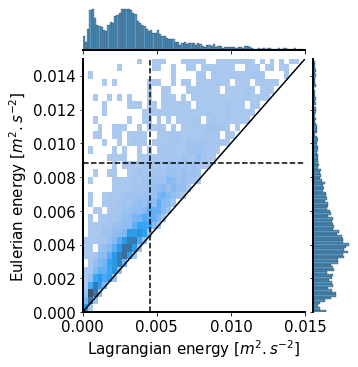

In [36]:
plot = sns.jointplot(x=ds_hf.L_energy.values.flatten(),y=ds_hf.E_energy.values.flatten()
                   ,xlim=(0,0.015),ylim=(0,0.015),kind='hist',height=5,
                     marginal_kws=dict(bins=np.linspace(0,0.015,100))
                    )
plot.ax_joint.axvline(x=ds_hf.L_energy.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.axhline(y=ds_hf.E_energy.mean(skipna=True).values,ls='--',c='k')
#plot.ax_marg_x.plot(x=ds_hf.L_energy.mean(skipna=True).values,ls='--',c='k')
#plot.ax_joint.axhline(y=ds_hf.E_energy.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.plot([0,1],[0,1],c='k');
plot.set_axis_labels(ylabel=r'Eulerian energy [$m^2.s^{-2}$]',xlabel=r'Lagrangian energy [$m^2.s^{-2}$]')
fig = plot.fig
plot.savefig(fig_dir+'energy_llc_pdf.png')

plot = sns.jointplot(x=(ds_predicted['El']+ds_predicted['El_V']).values.flatten(),
                     y=(ds_predicted['Ee']+ds_predicted['Ee_V']).values.flatten()
                   ,xlim=(0,0.015),ylim=(0,0.015),kind='hist',height=5,
                     marginal_kws=dict(bins=np.linspace(0,0.015,100))
                    )
plot.ax_joint.axvline(x=(ds_predicted['El']+ds_predicted['El_V']).mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.axhline(y=(ds_predicted['Ee']+ds_predicted['Ee_V']).mean(skipna=True).values,ls='--',c='k')
#plot.ax_marg_x.plot(x=ds_hf.L_energy.mean(skipna=True).values,ls='--',c='k')
#plot.ax_joint.axhline(y=ds_hf.E_energy.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.plot([0,1],[0,1],c='k');
plot.set_axis_labels(ylabel=r'Eulerian energy [$m^2.s^{-2}$]',xlabel=r'Lagrangian energy [$m^2.s^{-2}$]')


fig = plot.fig
plot.savefig(fig_dir+'energy_predicted_llc_pdf.png')

## Figure 4:

In [37]:
ds_hf_dl2['energy_ratio'] = ds_hf_dl2['L_energy']/ds_hf_dl2['E_energy']
ds_gdp = ds_gdp.rename({'energy':'L_energy'})
ds_gdp['E_energy'] = ds_gdp.L_energy/ds_hf_dl2.energy_ratio

In [40]:
from xhistogram.xarray import histogram
lon_bins = np.arange(-180,180,2)
lat_bins = np.arange(-60,60,2)
N = histogram(ds_hycom.lon_bin,ds_hycom.lat_bin,bins=[lon_bins,lat_bins])
ds_hycom_dl2 = (histogram(ds_hycom.lon_bin,ds_hycom.lat_bin,bins=[lon_bins,lat_bins],weights=ds_hycom.energy_15m
                        )/N).rename('energy_0m')
ds_hycom_dl2 = ds_hycom_dl2.rename({'lat_bin_bin':'lat_bin','lon_bin_bin':'lon_bin'})

In [41]:
ds_gdp = ds_gdp.where(np.isnan(ds_hycom_dl2)==False)

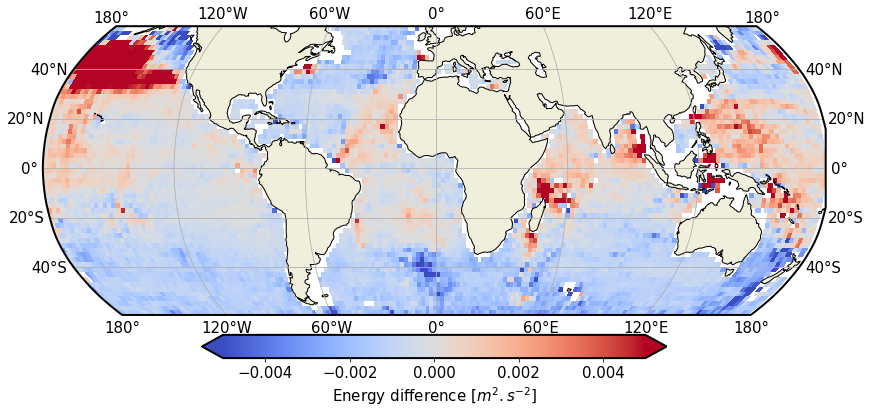

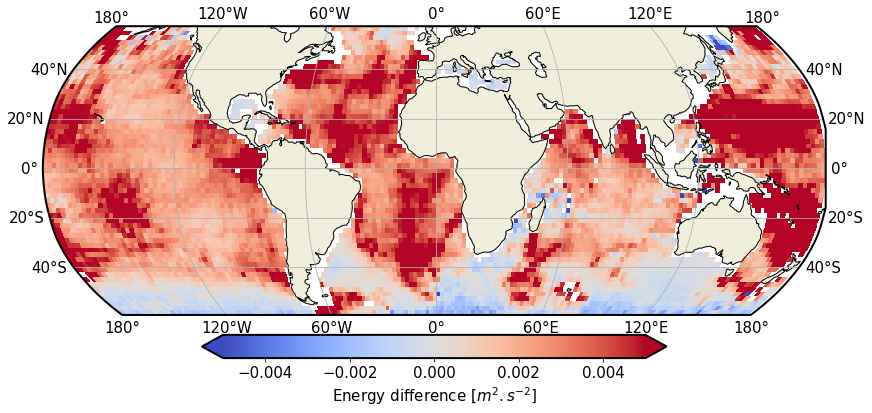

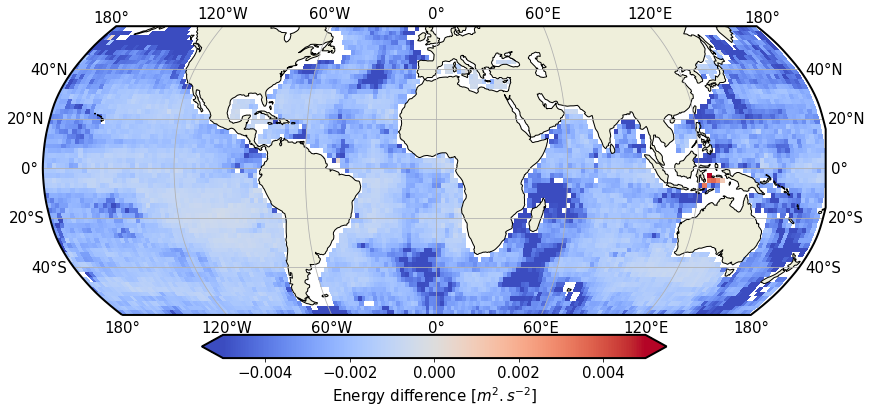

In [51]:
#Maps

#Hycom
fig = plt.figure(figsize=figsize)
kwargs.update({'label':r'Energy difference [$m^2.s^{-2}$]'})
fig,ax = plot_maps(ds_hycom_dl2-ds_gdp.E_energy,colmap='coolwarm',vlim=(-0.005,0.005),**kwargs)
#ax.set_title(r'$\frac{1}{2}<[\tilde{u}_E^2+\tilde{v}_E^2]_t>_b$',size=15)
fig.tight_layout()
fig.savefig(fig_dir+'energy_hycom_gdp.png')

#MITgcm
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_hf_dl2.E_energy-ds_gdp.E_energy,colmap='coolwarm',vlim=(-0.005,0.005),**kwargs)
#ax.set_title(r'$\frac{1}{2}<[\tilde{u}_E^2+\tilde{v}_E^2]_t>_b$',size=15)
fig.tight_layout()
fig.savefig(fig_dir+'energy_llc_gdp.png')

#HRET
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps((ds_hret['energy_total']-ds_gdp.E_energy),lat='lat_bin',colmap='coolwarm',vlim=(-5e-3,5e-3),**kwargs)
#ax.set_title('Unbiased GDP / HRET')
fig.tight_layout()
fig.savefig(fig_dir+'energy_hret_gdp.png')

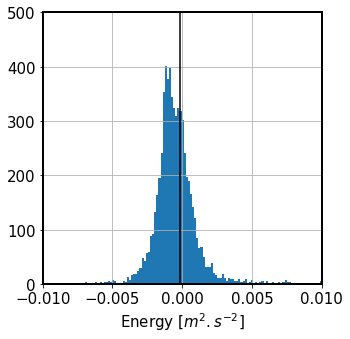

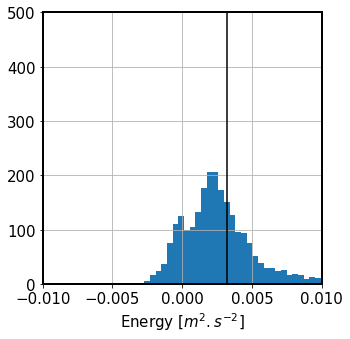

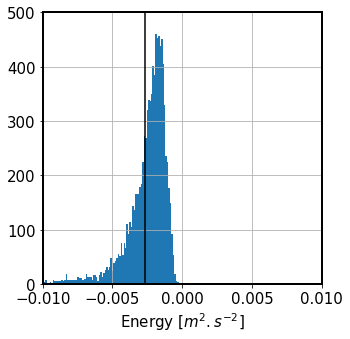

In [85]:
# Histogram

#Hycom:
fig,ax = plt.subplots(figsize=(5,5))
_ = (ds_hycom_dl2-ds_gdp.E_energy).plot.hist(ax=ax, bins=500,
                                             xlim=(-1e-2,1e-2),ylim=(0,500),density=True)
ax.grid();ax.axvline((ds_hycom_dl2-ds_gdp.E_energy).mean(),c='k')
ax.set_xlabel(r'Energy [$m^2.s^{-2}$]')
fig.savefig(fig_dir+'energy_hycom_gdp_pdf.png');
#MITgcm:
fig,ax = plt.subplots(figsize=(5,5))
_ = (ds_hf_dl2.E_energy-ds_gdp.E_energy).plot.hist(ax=ax, bins=500,xlim=(-1e-2,1e-2),ylim=(0,500),density=True)
ax.grid();ax.axvline((ds_hf_dl2.E_energy-ds_gdp.E_energy).mean(),c='k');
ax.set_xlabel(r'Energy [$m^2.s^{-2}$]')


fig.savefig(fig_dir+'energy_mitgcm_gdp_pdf.png');

#HRET:
fig,ax = plt.subplots(figsize=(5,5))
_ = (ds_hret['energy_total']-ds_gdp.E_energy).plot.hist(ax=ax, bins=500,xlim=(-1e-2,1e-2),ylim=(0,500),density=True)
ax.grid();ax.axvline((ds_hret['energy_total']-ds_gdp.E_energy).mean(),c='k');
ax.set_xlabel(r'Energy [$m^2.s^{-2}$]')
fig.savefig(fig_dir+'energy_hret_gdp_pdf.png');

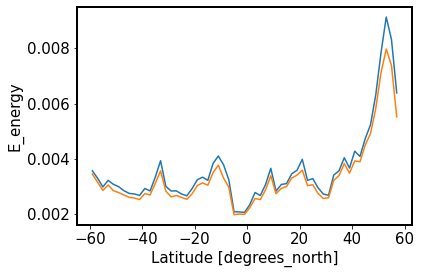

In [96]:
#((ds_gdp.E_energy.std('lon_bin'))/np.sqrt(ds_gdp.E_energy.count('lon_bin'))).plot()
((ds_gdp.E_energy.mean('lon_bin')+(ds_gdp.E_energy.std('lon_bin'))/np.sqrt(ds_gdp.E_energy.count('lon_bin')))).plot()
ds_gdp.E_energy.mean('lon_bin').plot()

In [121]:
def plot_zmean(v, ax=None, std=True, dim='lon_bin',**kwargs):
    x = v.mean('lon_bin')
    if ax is None:
        fig,ax = plt.subplots(figsize=(4,4))
    if std==True:
        x_std = ds_gdp.E_energy.std('lon_bin')/np.sqrt(ds_gdp.E_energy.count('lon_bin'))
        x.plot(ax=ax, **kwargs)
        ax.fill_between(x.lat_bin,x-x_std,x+x_std,color='grey',alpha=0.5)
    else:
        x.plot(ax=ax, **kwargs)

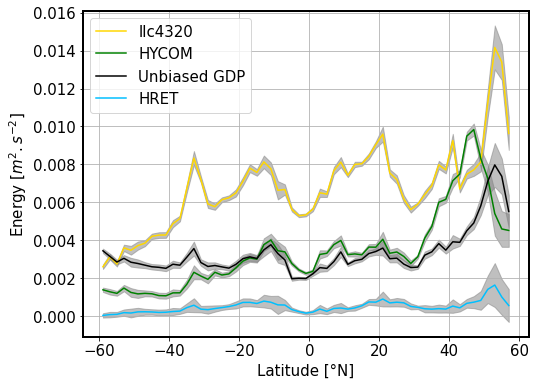

In [122]:
fig,ax = plt.subplots(figsize=(8,6))

plot_zmean(ds_hf_dl2.E_energy.where(np.isnan(ds_hycom_dl2)==False),ax=ax,**{'c':'gold','label':'llc4320'})
plot_zmean(ds_hycom_dl2,ax=ax,**{'c':'g','label':'HYCOM'})
plot_zmean(ds_gdp.E_energy,ax=ax,**{'c':'k','label':'Unbiased GDP'})
plot_zmean(ds_hret.energy_total,ax=ax,**{'c':'deepskyblue','label':'HRET'})
ax.grid();ax.legend();
ax.set_xlabel(r'Latitude [°N]');ax.set_ylabel(r'Energy [$m^2.s^{-2}$]');
fig.savefig(fig_dir+'energy_zonalmean.png');



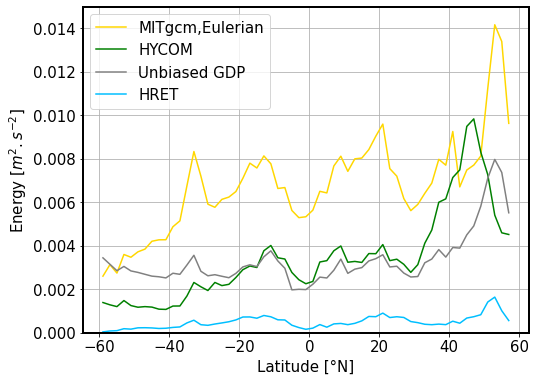

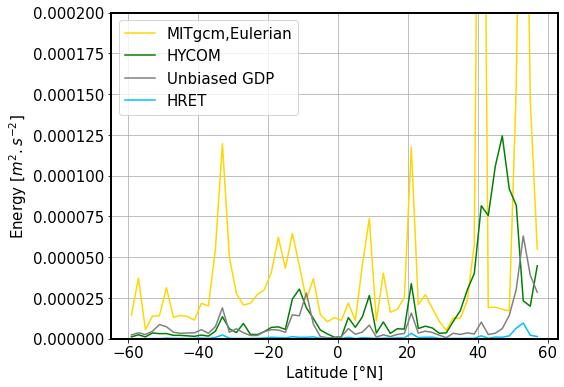

In [89]:
#MITgcm
fig,ax = plt.subplots(figsize=(8,6))
ds_hf_dl2.where(np.isnan(ds_hycom_dl2)==False).mean('lon_bin').E_energy.plot(label='MITgcm,Eulerian',c='gold')
#ds_hf_dl2.where(np.isnan(ds_hycom_dl2)==False).mean('lon_bin').L_energy.plot(label='MITgcm,Lagrangian',c='tan')
ds_hycom_dl2.mean('lon_bin').plot(label='HYCOM',c='g')
(ds_gdp.E_energy).mean('lon_bin').plot(ax=ax,label='Unbiased GDP',c='grey')
ds_hret.energy_total.mean('lon_bin').plot(ax=ax,label='HRET',c='deepskyblue')
#ds_mitgcm.mean('lon_bin').energy_0m.plot(ax=ax,label='MITgcm, spectra',ls='--',c='orange')
ax.set_ylabel(r'Energy [$m^2.s^{-2}$]');ax.set_xlabel(r'Latitude [°N]')
ax.grid();ax.legend();ax.set_ylim(0,0.015)
#ax.set_title('Adpated from Figure 14 (Arbic 2022)')
fig.savefig(fig_dir+'energy_zonalmean.png');

#MITgcm
fig,ax = plt.subplots(figsize=(8,6))
ds_hf_dl2.where(np.isnan(ds_hycom_dl2)==False).var('lon_bin').E_energy.plot(label='MITgcm,Eulerian',c='gold')
#ds_hf_dl2.where(np.isnan(ds_hycom_dl2)==False).mean('lon_bin').L_energy.plot(label='MITgcm,Lagrangian',c='tan')
ds_hycom_dl2.var('lon_bin').plot(label='HYCOM',c='g')
(ds_gdp.E_energy).var('lon_bin').plot(ax=ax,label='Unbiased GDP',c='grey')
ds_hret.energy_total.var('lon_bin').plot(ax=ax,label='HRET',c='deepskyblue')
#ds_mitgcm.mean('lon_bin').energy_0m.plot(ax=ax,label='MITgcm, spectra',ls='--',c='orange')
ax.set_ylabel(r'Energy [$m^2.s^{-2}$]');ax.set_xlabel(r'Latitude [°N]')
ax.grid();ax.legend();ax.set_ylim(0,0.0002)
#ax.set_title('Adpated from Figure 14 (Arbic 2022)')
fig.savefig(fig_dir+'energy_zonalvar.png');

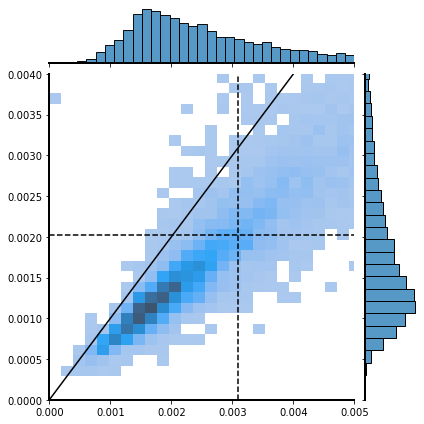

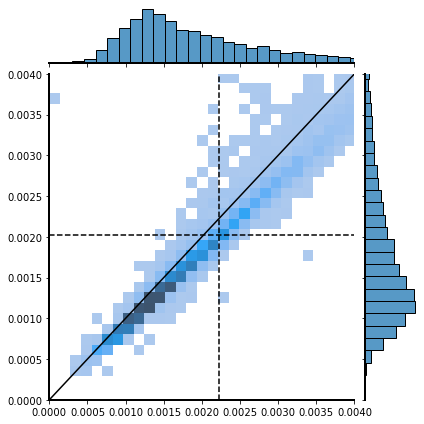

In [41]:
#gdp 
plot = sns.jointplot(x=ds_gdp.E_energy.values.flatten(),y=ds_GDP_dl2.values.flatten()
                   ,xlim=(0,0.005),ylim=(0,0.004),kind='hist',marginal_kws=dict(bins=np.linspace(0,0.015,100))
                    )
plot.ax_joint.axvline(x=ds_gdp.E_energy.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.axhline(y=ds_GDP_dl2.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.plot([0,1],[0,1],c='k')


plot = sns.jointplot(x=ds_gdp.L_energy.values.flatten(),y=ds_GDP_dl2.values.flatten()
                   ,xlim=(0,0.004),ylim=(0,0.004),kind='hist',marginal_kws=dict(bins=np.linspace(0,0.015,100))
                    )
plot.ax_joint.axvline(x=ds_gdp.L_energy.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.axhline(y=ds_GDP_dl2.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.plot([0,1],[0,1],c='k')

### HYCOM vs GDP

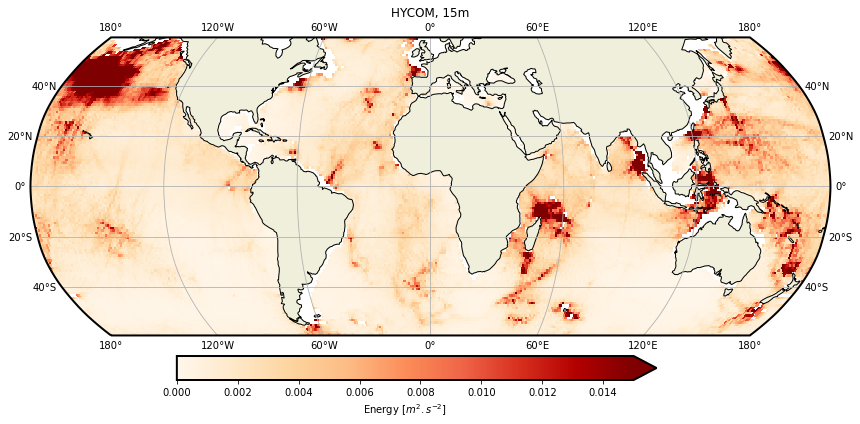

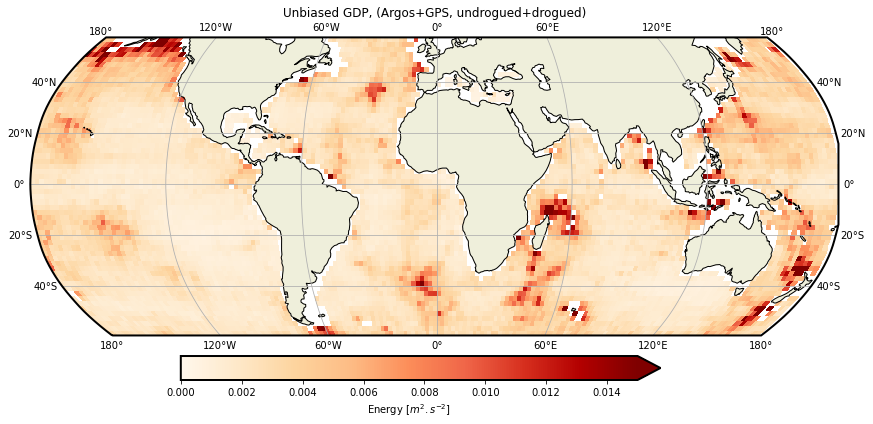

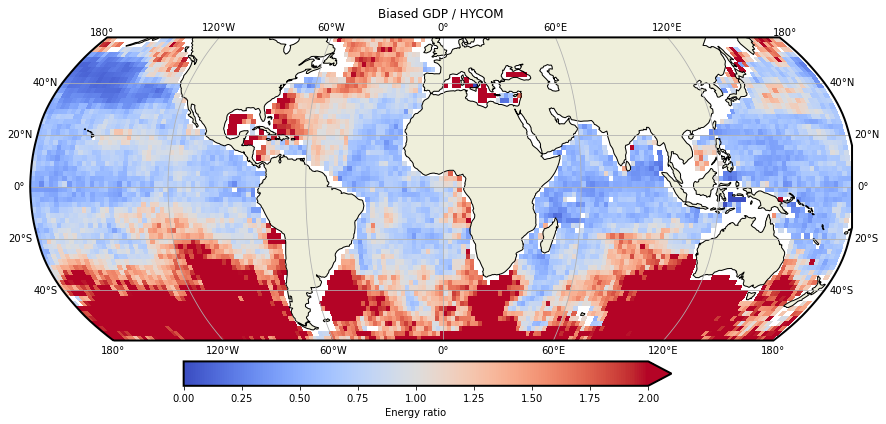

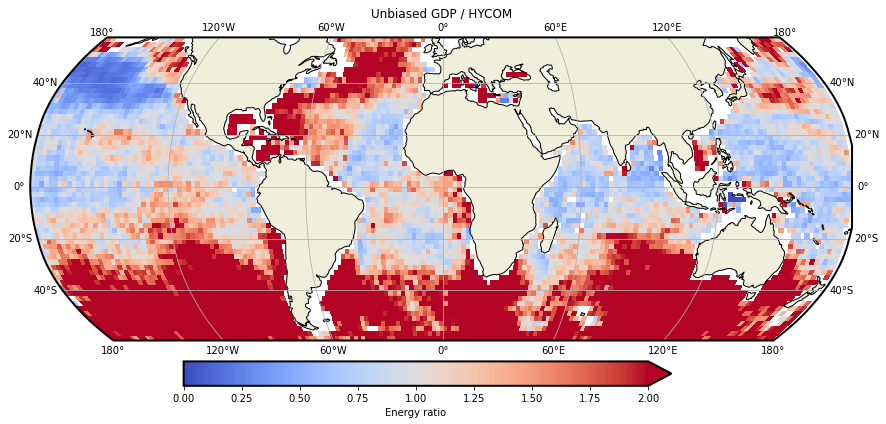

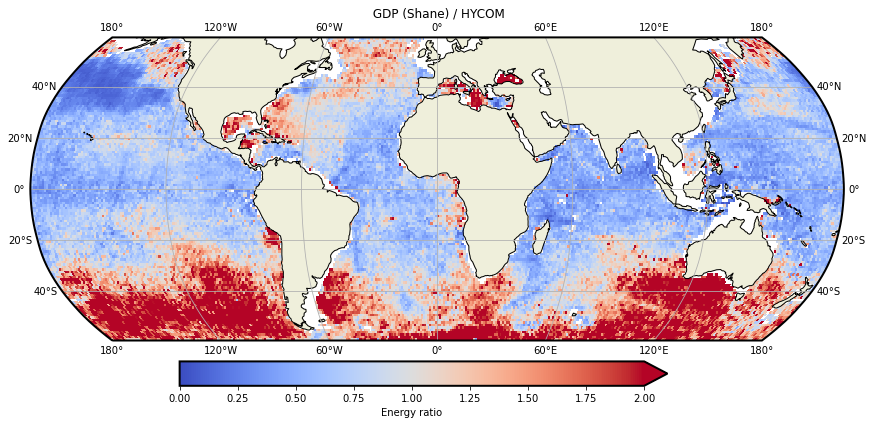

In [42]:
fig = plt.figure(figsize=figsize)
kwargs.update({'label':r'Energy [$m^2.s^{-2}$]'})
fig,ax = plot_maps(ds_hycom.energy_15m,colmap=cmap,vlim=(0,0.015),**kwargs)
ax.set_title('HYCOM, 15m')
fig.tight_layout()
#fig.savefig(fig_dir+'E_energy_hf.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
#kwargs.update({'label': 'Energy ratio'})
fig,ax = plot_maps(ds_gdp.E_energy,lat='lat_bin',colmap='OrRd',vlim=(0.,.015),**kwargs)
ax.set_title('Unbiased GDP, (Argos+GPS, undrogued+drogued)')
fig.tight_layout()
#fig.savefig(fig_dir+'Lgdp_energy.png',bbox_inches='tight')


fig = plt.figure(figsize=figsize)
kwargs.update({'label': 'Energy ratio'})
fig,ax = plot_maps(ds_gdp.L_energy/ds_hycom_dl2,lat='lat_bin',colmap='coolwarm',vlim=(0.,2),**kwargs)
ax.set_title('Biased GDP / HYCOM')
fig.tight_layout()
#fig.savefig(fig_dir+'Lgdp_energy.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
kwargs.update({'label': 'Energy ratio'})
fig,ax = plot_maps(ds_gdp.E_energy/ds_hycom_dl2,lat='lat_bin',colmap='coolwarm',vlim=(0.,2),**kwargs)
ax.set_title('Unbiased GDP / HYCOM')
fig.tight_layout()
#fig.savefig(fig_dir+'Lgdp_energy.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
kwargs.update({'label': 'Energy ratio'})
fig,ax = plot_maps(ds_GDP['energy_real']/ds_hycom.energy_0m,lat='lat_bin',colmap='coolwarm',vlim=(0.,2),**kwargs)
ax.set_title(' GDP (Shane) / HYCOM')
fig.tight_layout()




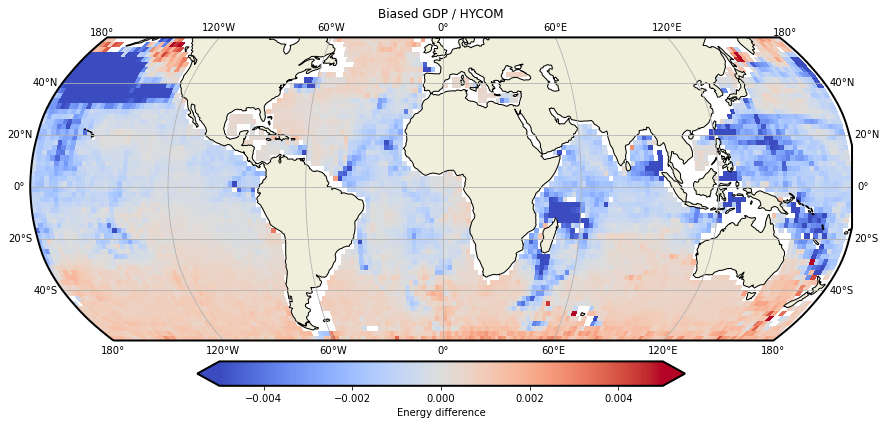

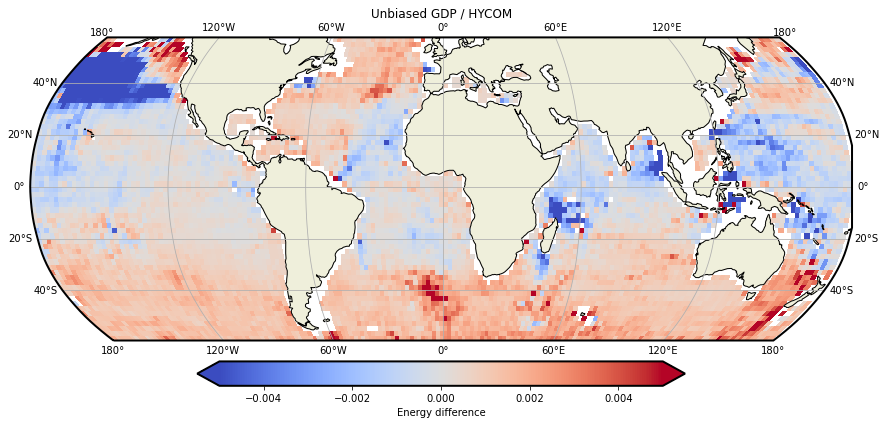

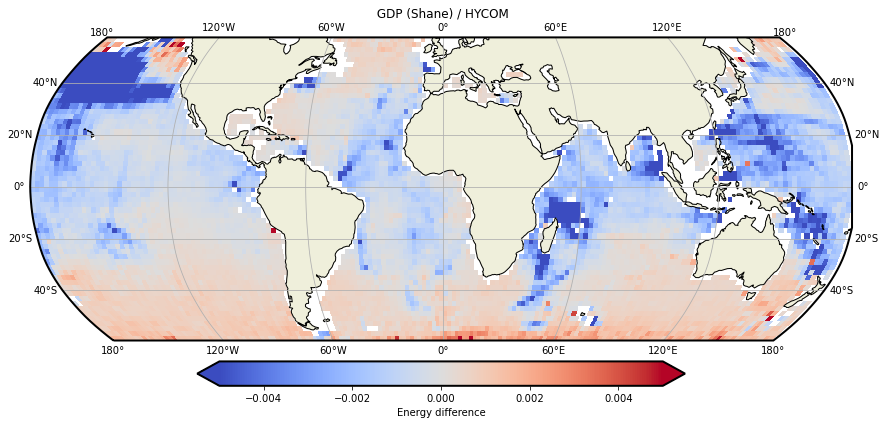

In [43]:
fig = plt.figure(figsize=figsize)
kwargs.update({'label': 'Energy difference'})
fig,ax = plot_maps((ds_gdp.L_energy-ds_hycom_dl2),lat='lat_bin',colmap='coolwarm',vlim=(-0.005,0.005),**kwargs)
ax.set_title('Biased GDP / HYCOM')
fig.tight_layout()
#fig.savefig(fig_dir+'Lgdp_energy.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
kwargs.update({'label': 'Energy difference'})
fig,ax = plot_maps((ds_gdp.E_energy-ds_hycom_dl2),lat='lat_bin',colmap='coolwarm',vlim=(-0.005,0.005),**kwargs)
ax.set_title('Unbiased GDP / HYCOM')
fig.tight_layout()
#fig.savefig(fig_dir+'Lgdp_energy.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
kwargs.update({'label': 'Energy difference'})
fig,ax = plot_maps((ds_GDP_dl2-ds_hycom_dl2),lat='lat_bin',colmap='coolwarm',vlim=(-0.005,0.005),**kwargs)
ax.set_title(' GDP (Shane) / HYCOM')
fig.tight_layout()

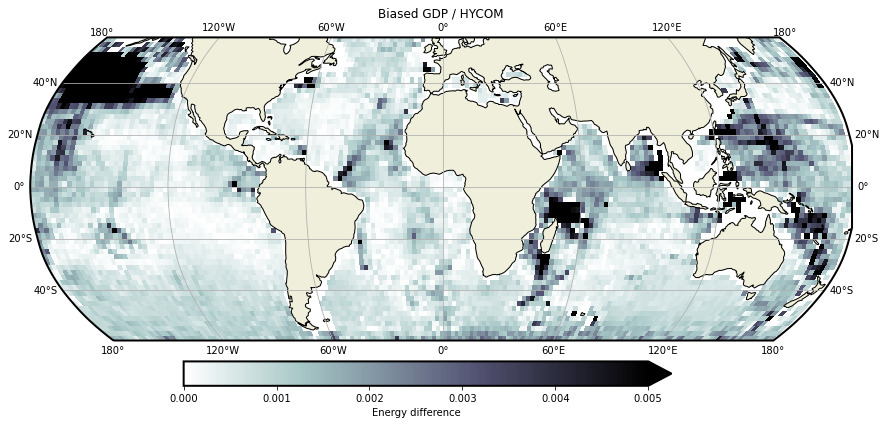

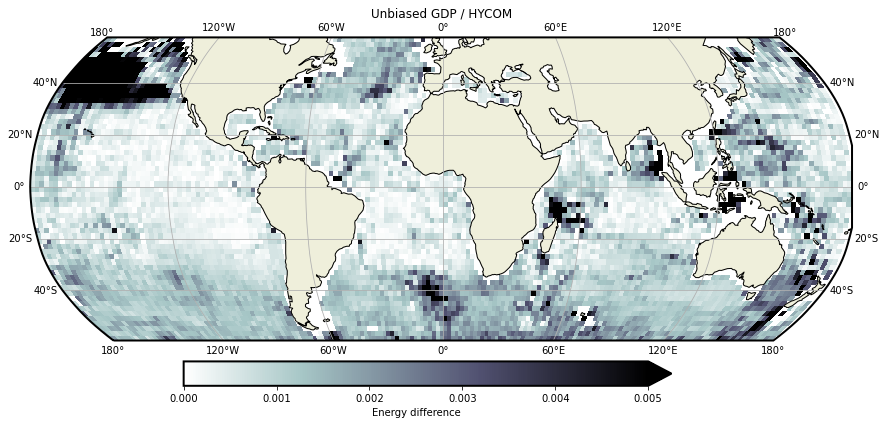

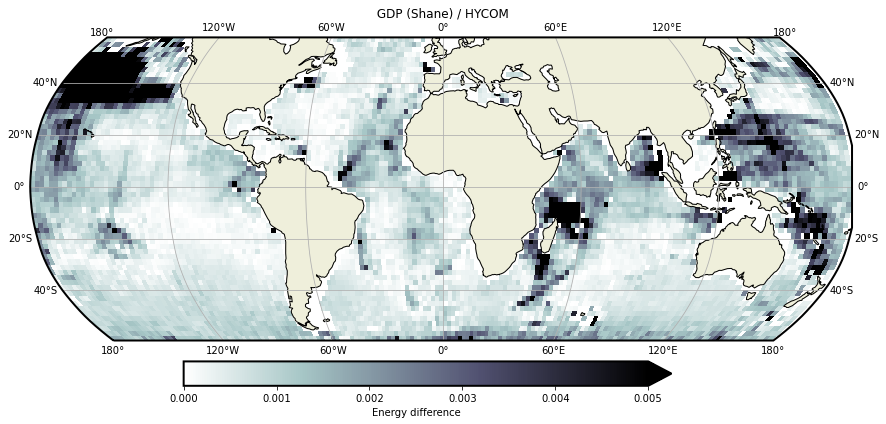

In [137]:
fig = plt.figure(figsize=figsize)
kwargs.update({'label': 'Energy difference'})
fig,ax = plot_maps(np.abs(ds_gdp.L_energy-ds_hycom_dl2),lat='lat_bin',colmap='bone_r',vlim=(0,0.005),**kwargs)
ax.set_title('Biased GDP / HYCOM')
fig.tight_layout()
#fig.savefig(fig_dir+'Lgdp_energy.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
kwargs.update({'label': 'Energy difference'})
fig,ax = plot_maps(np.abs(ds_gdp.E_energy-ds_hycom_dl2),lat='lat_bin',colmap='bone_r',vlim=(0.,0.005),**kwargs)
ax.set_title('Unbiased GDP / HYCOM')
fig.tight_layout()
#fig.savefig(fig_dir+'Lgdp_energy.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
kwargs.update({'label': 'Energy difference'})
fig,ax = plot_maps(np.abs(ds_GDP_dl2-ds_hycom_dl2),lat='lat_bin',colmap='bone_r',vlim=(0.,0.005),**kwargs)
ax.set_title(' GDP (Shane) / HYCOM')
fig.tight_layout()

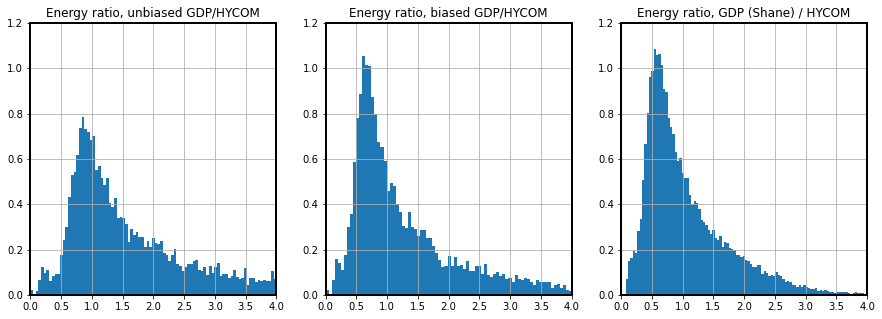

In [44]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
_ = (ds_gdp.E_energy/ds_hycom_dl2).plot.hist(bins=300,ax=ax[0],xlim=(0,4),ylim=(0,1.2),density=True)
ax[0].set_title('Energy ratio, unbiased GDP/HYCOM')

#fig,ax = plt.subplots(figsize=(5,5))
_ = (ds_gdp.L_energy/ds_hycom_dl2).plot.hist(bins=300,ax=ax[1],xlim=(0,4),ylim=(0,1.2),density=True)
ax[1].set_title('Energy ratio, biased GDP/HYCOM')

#fig,ax = plt.subplots(figsize=(5,5))
_ = (ds_GDP['energy_real']/ds_hycom.energy_0m).plot.hist(bins=1000,ax=ax[2],xlim=(0,4),ylim=(0,1.2),density=True)
ax[2].set_title('Energy ratio, GDP (Shane) / HYCOM')

for a in ax:
    a.grid()

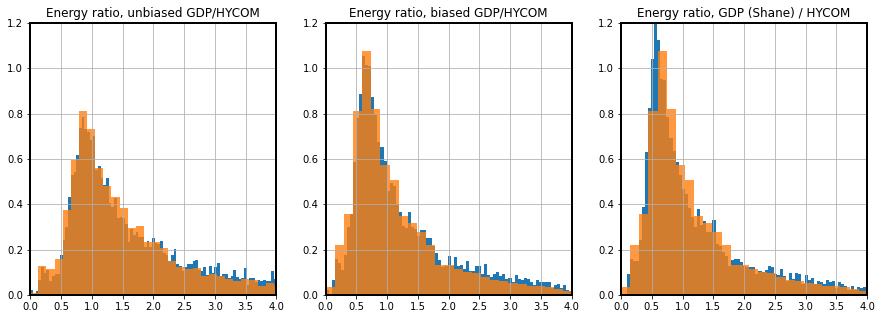

In [45]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
_ = ax[0].hist((ds_gdp.E_energy/ds_hycom_dl2).values.flatten(),bins=300,density=True)
_=ax[0].hist((ds_gdp.E_energy/ds_hycom_dl2).values.flatten(),density=True,bins=100,
             weights=ds_gdp.E_energy.values.flatten(),alpha=0.8)
ax[0].set_xlim(0,4);ax[0].set_ylim(0,1.2);
ax[0].set_title('Energy ratio, unbiased GDP/HYCOM')

#fig,ax = plt.subplots(figsize=(5,5))
_ = ax[1].hist((ds_gdp.L_energy/ds_hycom_dl2).values.flatten(),bins=300,density=True)
_=ax[1].hist((ds_gdp.L_energy/ds_hycom_dl2).values.flatten(),density=True,bins=100,
             weights=ds_gdp.L_energy.values.flatten(),alpha=0.8)
ax[1].set_xlim(0,4);ax[1].set_ylim(0,1.2);
ax[1].set_title('Energy ratio, biased GDP/HYCOM')

#fig,ax = plt.subplots(figsize=(5,5))
_ = ax[2].hist((ds_GDP_dl2/ds_hycom_dl2).values.flatten(),bins=300,density=True)
_=ax[2].hist((ds_gdp.L_energy/ds_hycom_dl2).values.flatten(),density=True,bins=100,
             weights=ds_gdp.L_energy.values.flatten(),alpha=0.8)
ax[2].set_xlim(0,4);ax[2].set_ylim(0,1.2);
ax[2].set_title('Energy ratio, GDP (Shane) / HYCOM')

for a in ax:
    a.grid()

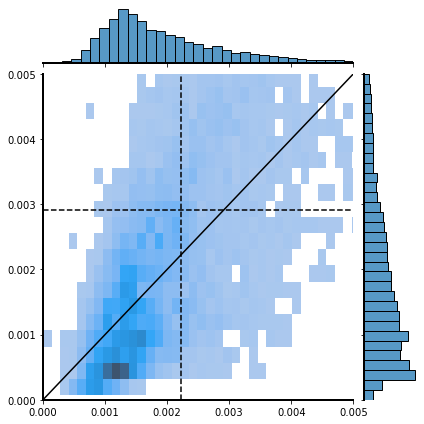

<Figure size 432x288 with 0 Axes>

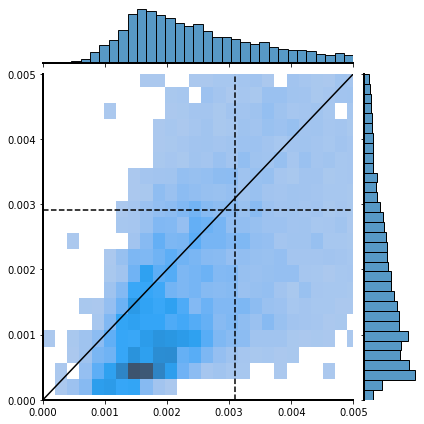

<Figure size 432x288 with 0 Axes>

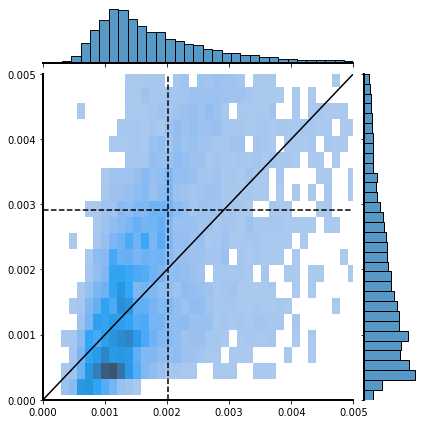

In [46]:
#Biased GDP / HYCOM
plot = sns.jointplot(x=ds_gdp.L_energy.values.flatten(),y=ds_hycom_dl2.values.flatten()
                   ,xlim=(0,0.005),ylim=(0,0.005),kind='hist',marginal_kws=dict(bins=np.linspace(0,0.015,100))
                    )
plot.ax_joint.axvline(x=ds_gdp.L_energy.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.axhline(y=ds_hycom_dl2.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.plot([0,1],[0,1],c='k')

#Unbiased GDP / HYCOM
plt.figure()
plot = sns.jointplot(x=ds_gdp.E_energy.values.flatten(),y=ds_hycom_dl2.values.flatten()
                   ,xlim=(0,0.005),ylim=(0,0.005),kind='hist',marginal_kws=dict(bins=np.linspace(0,0.015,100))
                    )
plot.ax_joint.axvline(x=ds_gdp.E_energy.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.axhline(y=ds_hycom_dl2.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.plot([0,1],[0,1],c='k')

#Biased GDP (Elipot) / HYCOM
plt.figure()
plot = sns.jointplot(x=ds_GDP_dl2.values.flatten(),y=ds_hycom_dl2.values.flatten()
                   ,xlim=(0,0.005),ylim=(0,0.005),kind='hist',marginal_kws=dict(bins=np.linspace(0,0.015,100))
                    )
plot.ax_joint.axvline(x=ds_GDP_dl2.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.axhline(y=ds_hycom_dl2.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.plot([0,1],[0,1],c='k')

In [218]:
_E = (dsE_yu.sel(frequency_band='semidiurnal_0dot2')).where(np.isnan(ds_hycom.energy_0m)==False)
_L = (dsL_yu.sel(frequency_band='semidiurnal_0dot2')).where(np.isnan(ds_hycom.energy_0m)==False)

Text(0.5, 1.0, 'Adpated from Figure 14 (Arbic 2022)')

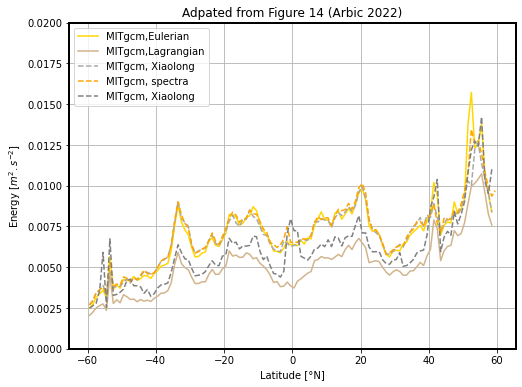

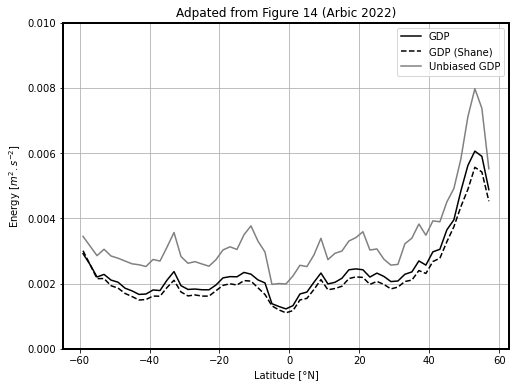

In [220]:
#MITgcm
fig,ax = plt.subplots(figsize=(8,6))
ds_hf.where(np.isnan(ds_hycom.energy_0m)==False).mean('lon_bin').E_energy.plot(label='MITgcm,Eulerian',c='gold')
ds_hf.where(np.isnan(ds_hycom.energy_0m)==False).mean('lon_bin').L_energy.plot(label='MITgcm,Lagrangian',c='tan')
(_E).mean('lon_bin').plot(ax=ax,label='MITgcm, Xiaolong',c='darkgrey',ls='--')
ds_mitgcm.mean('lon_bin').energy_0m.plot(ax=ax,label='MITgcm, spectra',ls='--',c='orange')
(_L).mean('lon_bin').plot(ax=ax,label='MITgcm, Xiaolong',c='grey',ls='--')
ax.set_ylabel(r'Energy [$m^2.s^{-2}$]');ax.set_xlabel(r'Latitude [°N]')
ax.grid();ax.legend();ax.set_ylim(0,0.02)
ax.set_title('Adpated from Figure 14 (Arbic 2022)')

#GDP
fig,ax = plt.subplots(figsize=(8,6))
(ds_gdp.L_energy).mean('lon_bin').plot(ax=ax,label='GDP',c='k')
(ds_GDP_dl2).mean('lon_bin').plot(ax=ax,label='GDP (Shane)',c='k',ls='--')
(ds_gdp.E_energy).mean('lon_bin').plot(ax=ax,label='Unbiased GDP',c='grey')
ax.set_ylabel(r'Energy [$m^2.s^{-2}$]');ax.set_xlabel(r'Latitude [°N]')
ax.grid();ax.legend();ax.set_ylim(0,0.01)
ax.set_title('Adpated from Figure 14 (Arbic 2022)')

Text(0.5, 1.0, 'Adpated from Figure 14 (Arbic 2022)')

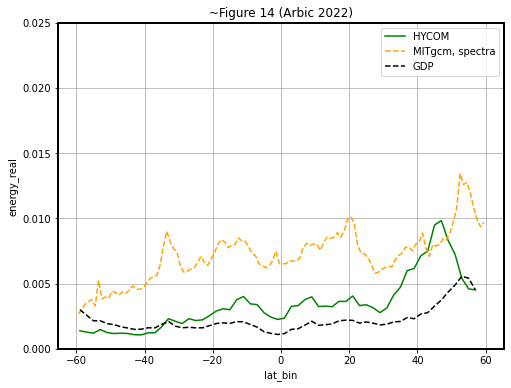

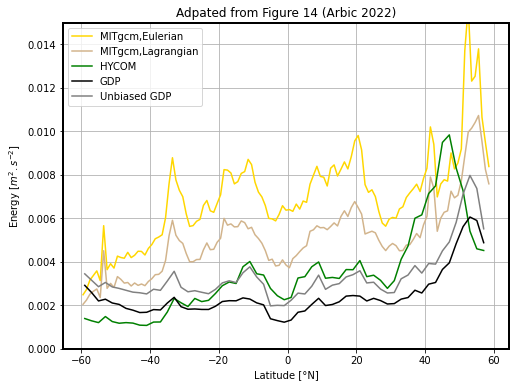

In [47]:
fig,ax = plt.subplots(figsize=(8,6))
ds_hycom_dl2.mean('lon_bin').plot(ax=ax,label='HYCOM',c='g')
ds_mitgcm.mean('lon_bin').energy_0m.plot(ax=ax,label='MITgcm, spectra',ls='--',c='orange')
(ds_GDP_dl2).mean('lon_bin').plot(ax=ax,label='GDP',c='k',ls='--')
ax.set_title('~Figure 14 (Arbic 2022)')
ax.grid();ax.legend();ax.set_ylim(0,0.025)

fig,ax = plt.subplots(figsize=(8,6))
ds_hf.where(np.isnan(ds_hycom.energy_0m)==False).mean('lon_bin').E_energy.plot(label='MITgcm,Eulerian',c='gold')
ds_hf.where(np.isnan(ds_hycom.energy_0m)==False).mean('lon_bin').L_energy.plot(label='MITgcm,Lagrangian',c='tan')
ds_hycom_dl2.mean('lon_bin').plot(ax=ax,label='HYCOM',c='g')
#ds_mitgcm.mean('lon_bin').energy_0m.plot()
#ds_mitgcm.mean('lon_bin').energy_0m.plot(ax=ax,label='MITgcm, spectra',ls='--',c='orange')
(ds_gdp.L_energy).mean('lon_bin').plot(ax=ax,label='GDP',c='k')
#(ds_GDP_dl2).mean('lon_bin').plot(ax=ax,label='GDP (Shane)',c='k',ls='--')
(ds_gdp.E_energy).mean('lon_bin').plot(ax=ax,label='Unbiased GDP',c='grey')
#(dsL_yu.sel(frequency_band='semidiurnal_0dot2')).mean('lon_bin').plot(ax=ax,label='GDP, Xiaolong',c='grey')
ax.set_ylabel(r'Energy [$m^2.s^{-2}$]');ax.set_xlabel(r'Latitude [°N]')
ax.grid();ax.legend();ax.set_ylim(0,0.015)
ax.set_title('Adpated from Figure 14 (Arbic 2022)')

In [48]:
#Removing North-east Pacific
ds_hycom_nep = ds_hycom_dl2.copy()
mask_x = ds_hycom_nep.where(ds_hycom_nep.sel(lat_bin=slice(25,55),
                                             lon_bin=slice(-180,-140))>0.015,drop=True).lon_bin
mask_y = ds_hycom_nep.where(ds_hycom_nep.sel(lat_bin=slice(25,55),
                                             lon_bin=slice(-180,-140))>0.015,drop=True).lat_bin

ds_hycom_nep.loc[{'lon_bin':mask_x,'lat_bin':mask_y}] = np.nan

Text(0.5, 1.0, 'Figure 14 (Arbic 2022) + my data')

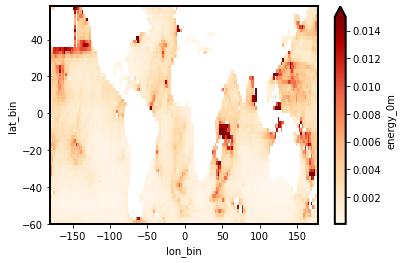

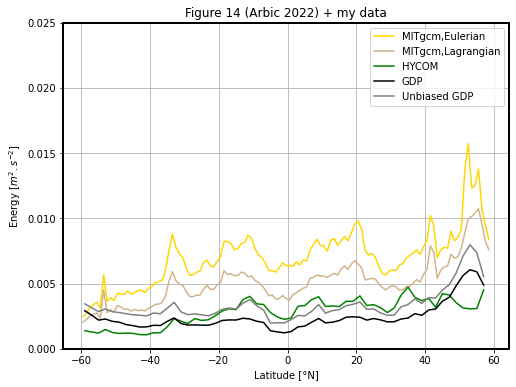

In [49]:
ds_hycom_nep.plot(y='lat_bin',vmax=0.015,cmap='OrRd')
fig,ax = plt.subplots(figsize=(8,6))
ds_hf.where(np.isnan(ds_hycom.energy_0m)==False).mean('lon_bin').E_energy.plot(label='MITgcm,Eulerian',c='gold')
ds_hf.where(np.isnan(ds_hycom.energy_0m)==False).mean('lon_bin').L_energy.plot(label='MITgcm,Lagrangian',c='tan')
ds_hycom_nep.mean('lon_bin').plot(ax=ax,label='HYCOM',c='g')
#ds_mitgcm.mean('lon_bin').energy_0m.plot(ax=ax,label='MITgcm, spectra',ls='--',c='orange')
(ds_gdp.L_energy).mean('lon_bin').plot(ax=ax,label='GDP',c='k')
#(ds_GDP_dl2).mean('lon_bin').plot(ax=ax,label='GDP (Shane)',c='k',ls='--')
(ds_gdp.E_energy).mean('lon_bin').plot(ax=ax,label='Unbiased GDP',c='grey')
#(dsL_yu.sel(frequency_band='semidiurnal_0dot2')).mean('lon_bin').plot(ax=ax,label='GDP, Xiaolong',c='grey')
ax.set_ylabel(r'Energy [$m^2.s^{-2}$]');ax.set_xlabel(r'Latitude [°N]')
ax.grid();ax.legend();ax.set_ylim(0,0.025)
ax.set_title('Figure 14 (Arbic 2022) + my data')

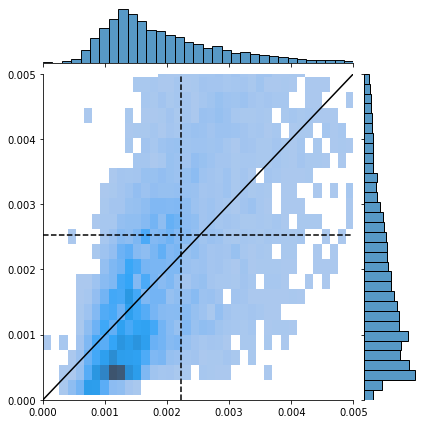

<Figure size 432x288 with 0 Axes>

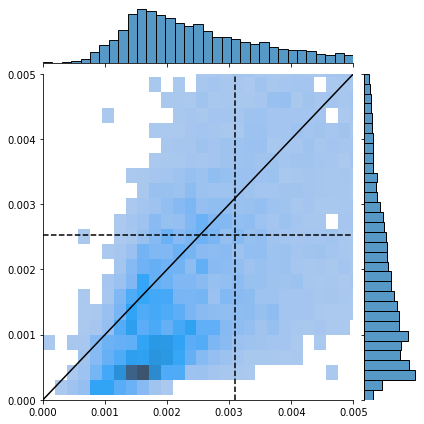

<Figure size 432x288 with 0 Axes>

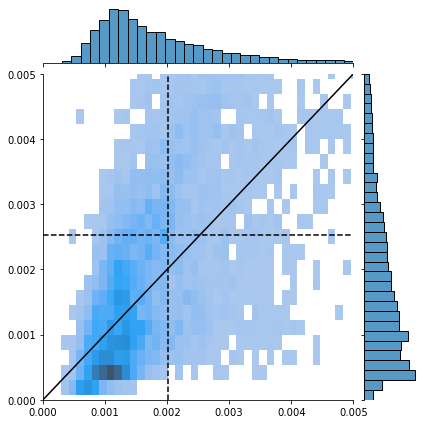

In [193]:
#Biased GDP / HYCOM
plot = sns.jointplot(x=ds_gdp.L_energy.values.flatten(),y=ds_hycom_nep.values.flatten()
                   ,xlim=(0,0.005),ylim=(0,0.005),kind='hist',marginal_kws=dict(bins=np.linspace(0,0.015,100))
                    )
plot.ax_joint.axvline(x=ds_gdp.L_energy.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.axhline(y=ds_hycom_nep.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.plot([0,1],[0,1],c='k')

#Unbiased GDP / HYCOM
plt.figure()
plot = sns.jointplot(x=ds_gdp.E_energy.values.flatten(),y=ds_hycom_nep.values.flatten()
                   ,xlim=(0,0.005),ylim=(0,0.005),kind='hist',marginal_kws=dict(bins=np.linspace(0,0.015,100))
                    )
plot.ax_joint.axvline(x=ds_gdp.E_energy.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.axhline(y=ds_hycom_nep.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.plot([0,1],[0,1],c='k')

#Biased GDP (Elipot) / HYCOM
plt.figure()
plot = sns.jointplot(x=ds_GDP_dl2.values.flatten(),y=ds_hycom_nep.values.flatten()
                   ,xlim=(0,0.005),ylim=(0,0.005),kind='hist',marginal_kws=dict(bins=np.linspace(0,0.015,100))
                    )
plot.ax_joint.axvline(x=ds_GDP_dl2.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.axhline(y=ds_hycom_nep.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.plot([0,1],[0,1],c='k')

In [201]:
# Removing low energy area:
mask_low = ds_gdp.L_energy.where(ds_gdp.L_energy>0.002)


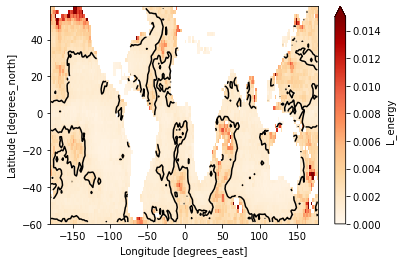

In [202]:
ds_gdp.L_energy.plot(y='lat_bin',cmap='OrRd',vmax=0.015)
ds_gdp.L_energy.plot.contour(y='lat_bin',colors='k',levels=[0.002])

### Stationary vs nonstationary

amplitude     phase         omega  alpha  species
m3        0.000000  0.000000  0.000000e+00  0.000      0.0
eps2      0.000000  0.000000  0.000000e+00  0.000      0.0
n4        0.000000  0.000000  0.000000e+00  0.000      0.0
mtm       0.000000  0.000000  0.000000e+00  0.000      0.0
sa        0.000000  0.000000  0.000000e+00  0.000      0.0
msqm      0.000000  0.000000  0.000000e+00  0.000      0.0
lambda2   0.000000  0.000000  0.000000e+00  0.000      0.0
msf       0.000000  0.000000  0.000000e+00  0.000      0.0
mks2      0.000000  0.000000  0.000000e+00  0.000      0.0
s4        0.000000  0.000000  0.000000e+00  0.000      0.0
s1        0.000000  0.000000  0.000000e+00  0.000      0.0
r2        0.000000  0.000000  0.000000e+00  0.000      0.0
ssa       0.019567  3.487600  3.982000e-07  0.693      0.0
mm        0.022191  1.964022  2.639200e-06  0.693      0.0
mf        0.042041  1.756042  5.323400e-06  0.693      0.0
q1        0.019273  5.877718  6.495854e-05  0.695      1.0
o1        0.100661  1.558554  6.759774e-05  0.695      1.0
p1        0.046848  6.110182  7.252295e-05  0.706      1.0
k1        0.141565  0.173004  7.292117e-05  0.736      1.0
j1        0.007915  2.137025  7.556036e-05  0.695      1.0
2n2       0.006141  4.086700  1.352405e-04  0.693      2.0
mu2       0.007408  3.463115  1.355937e-04  0.693      2.0
n2        0.046397  6.050721  1.378797e-04  0.693      2.0
nu2       0.008811  5.427137  1.382329e-04  0.693      2.0
m2        0.244100  1.731558  1.405189e-04  0.693      2.0
l2        0.006931  0.553987  1.431581e-04  0.693      2.0
t2        0.006608  0.052842  1.452450e-04  0.693      2.0
s2        0.112743  0.000000  1.454441e-04  0.693      2.0
k2        0.030684  3.487600  1.458423e-04  0.693      2.0
mn4       0.000000  1.499093  2.783984e-04  0.693      0.0
m4        0.000000  3.463115  2.810377e-04  0.693      0.0
ms4       0.000000  1.731558  2.859630e-04  0.693      0.0
m6        0.000000  5.194673  4.215566e-04  0.693      0.0
m8        0.000000  6.926230  5.620755e-04  0.693      0.0

In [51]:
_c = c.loc[c.species==2.] # select semidiurnal constituents
_c = _c.sort_values("amplitude", ascending=False)

#Loading Ed Zaron files:
M2_stationary = xr.open_dataset(root_dir+'M2ke_2x2.nc')

M2_stationary = M2_stationary.rename({'lat_':'lat_bin','lon_':'lon_bin'})

M2_stationary = M2_stationary.sel(lat_bin=slice(-60,60))#.ke_.plot()
M2_stationary.coords['lon_bin'] = (M2_stationary.coords['lon_bin'] + 180) % 360 - 180
#M2_stationary['ke_'] = M2_stationary['ke_'].sortby('lon_bin')
_M2 = M2_stationary['ke_']
_M2 = _M2.sortby('lon_bin')
_M2 = _M2.where(_M2>0)

# Correction HRET
ds_hret = xr.Dataset({'energy_m2':_M2})

ds_hret["equilibirum_amplitude"] = _c["amplitude"]
ds_hret = ds_hret.rename({'dim_0':'species'})
ratio = (ds_hret['equilibirum_amplitude']).sum('species')/(ds_hret['equilibirum_amplitude'].sel(species='m2')**1)
ds_hret['energy_total'] = ratio*ds_hret.energy_m2
ds_hret = ds_hret.where(np.isnan(ds_gdp.L_energy)==False)
#ds_hret['energy_total'] = (ratio*ds_hret.energy_m2)

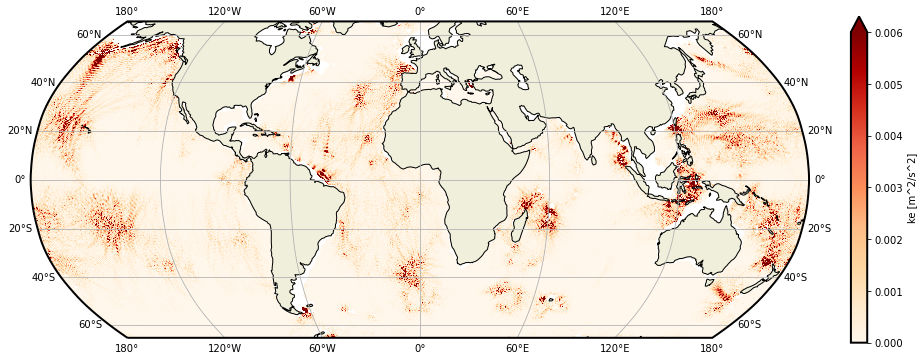

In [71]:
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(ratio.values*M2_stationary.ke.where(M2_stationary.ke>0),colmap='OrRd',vlim=(0,0.006),lat='lat')

In [106]:
from scipy.ndimage.filters import gaussian_filter
ds_gdp['L_energy_smooth'] = (["lon_bin","lat_bin"],
                                 gaussian_filter(ds_gdp.L_energy.fillna(-1),sigma=[2,2],order=0,mode='constant'))
ds_gdp['L_energy_smooth'] = ds_gdp['L_energy_smooth'].where(ds_gdp['L_energy_smooth']>0)

ds_gdp['E_energy_smooth'] = (["lon_bin","lat_bin"],
                                 gaussian_filter(ds_gdp.E_energy.fillna(-1),sigma=[2,2],order=0,mode='constant'))
ds_gdp['E_energy_smooth'] = ds_gdp['E_energy_smooth'].where(ds_gdp['E_energy_smooth']>0)

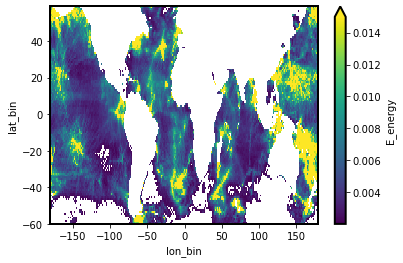

In [55]:
ds_hf.E_energy.where(ds_hf.E_energy>0.002).plot(y='lat_bin',vmax=0.015)

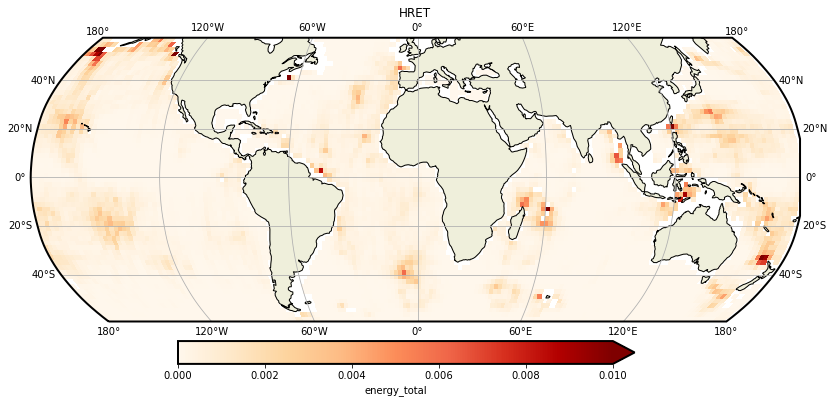

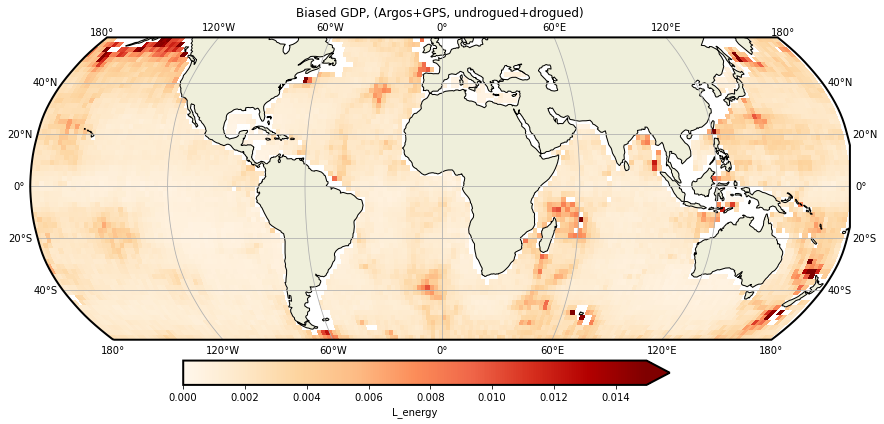

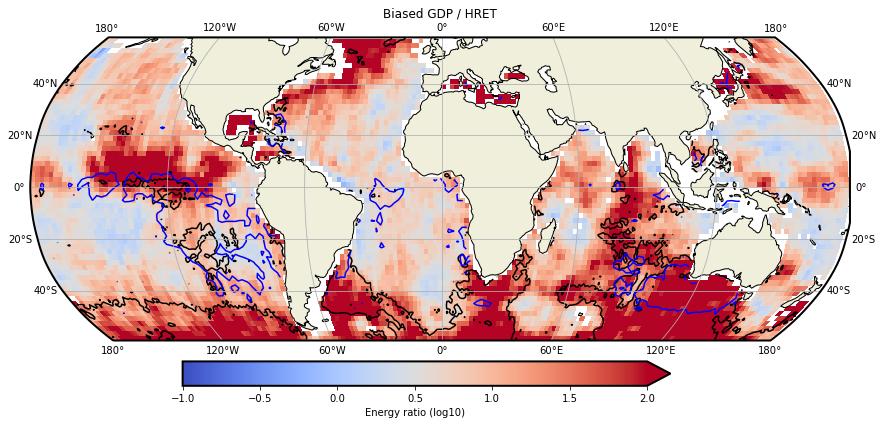

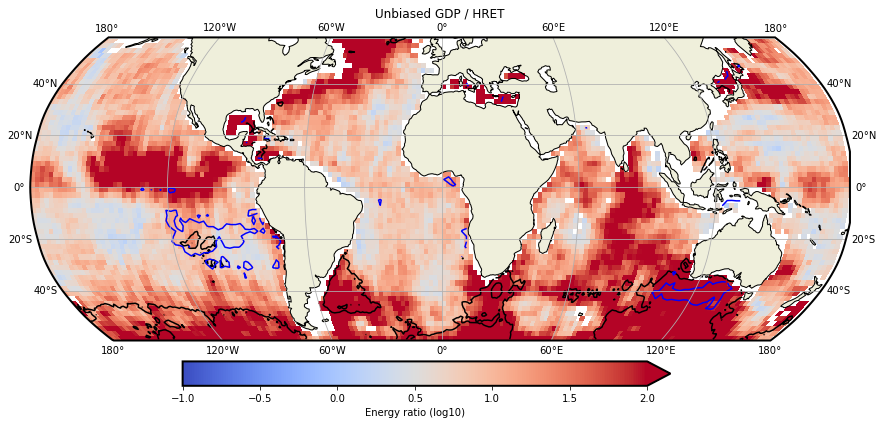

In [130]:
kwargs = {'orientation':'horizontal','pad':0.06,'fraction':0.07}

fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(ds_hret['energy_total'],
                   colmap='OrRd',vlim=(0,0.01),lat='lat_bin',**kwargs)
ax.set_title('HRET')
fig = plt.figure(figsize=(15,6))
#kwargs.update({'label': 'Energy ratio'})
fig,ax = plot_maps(ds_gdp.L_energy,lat='lat_bin',colmap='OrRd',vlim=(0.,.015),**kwargs)
ax.set_title('Biased GDP, (Argos+GPS, undrogued+drogued)')
fig.tight_layout()

fig = plt.figure(figsize=(15,6))
kwargs.update({'label': 'Energy ratio (log10)'})
fig,ax = plot_maps(np.log10(ds_gdp.L_energy/ds_hret['energy_total']),lat='lat_bin',colmap='coolwarm',vlim=(-1.,2),**kwargs)
ds_hf.L_energy.plot.contour(ax=ax,levels=[0.002],colors='k',y='lat_bin',zorder=1,transform=ccrs.PlateCarree())
ds_gdp.L_energy.plot.contour(ax=ax,levels=[0.001],colors='b',y='lat_bin',zorder=1,transform=ccrs.PlateCarree())
ax.set_title('Biased GDP / HRET')
fig.tight_layout()

fig = plt.figure(figsize=(15,6))
kwargs.update({'label': 'Energy ratio (log10)'})
fig,ax = plot_maps(np.log10(ds_gdp.E_energy/ds_hret['energy_total']),lat='lat_bin',colmap='coolwarm',vlim=(-1.,2),**kwargs)
ds_hf.E_energy.plot.contour(ax=ax,levels=[0.002],colors='k',y='lat_bin',zorder=1,transform=ccrs.PlateCarree())
ds_gdp.E_energy.plot.contour(ax=ax,levels=[0.001],colors='b',y='lat_bin',zorder=1,transform=ccrs.PlateCarree())
ax.set_title('Unbiased GDP / HRET')
fig.tight_layout()

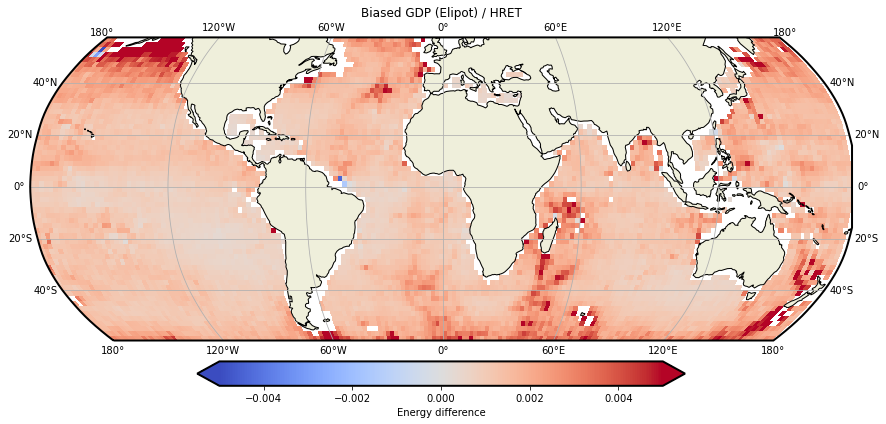

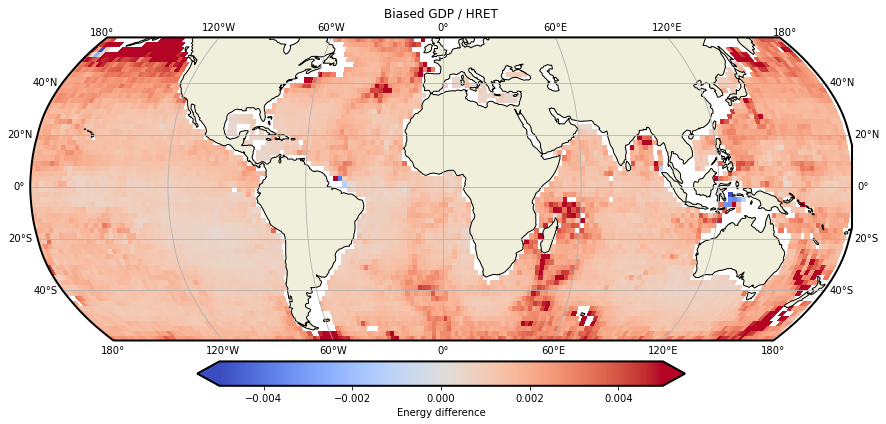

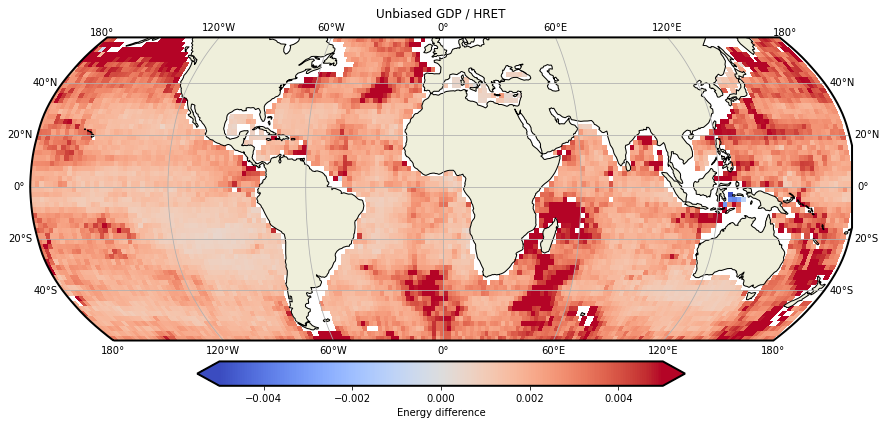

In [133]:
fig = plt.figure(figsize=(15,6))
kwargs.update({'label': 'Energy difference'})
fig,ax = plot_maps((ds_GDP_dl2-ds_hret['energy_total']),lat='lat_bin',colmap='coolwarm',vlim=(-5e-3,5e-3),**kwargs)
ax.set_title('Biased GDP (Elipot) / HRET')
fig.tight_layout()

fig = plt.figure(figsize=(15,6))
kwargs.update({'label': 'Energy difference'})
fig,ax = plot_maps((ds_gdp.L_energy-ds_hret['energy_total']),lat='lat_bin',colmap='coolwarm',vlim=(-5e-3,5e-3),**kwargs)
ax.set_title('Biased GDP / HRET')
fig.tight_layout()

fig = plt.figure(figsize=(15,6))
kwargs.update({'label': 'Energy difference'})
fig,ax = plot_maps((ds_gdp.E_energy-ds_hret['energy_total']),lat='lat_bin',colmap='coolwarm',vlim=(-5e-3,5e-3),**kwargs)
ax.set_title('Unbiased GDP / HRET')
fig.tight_layout()

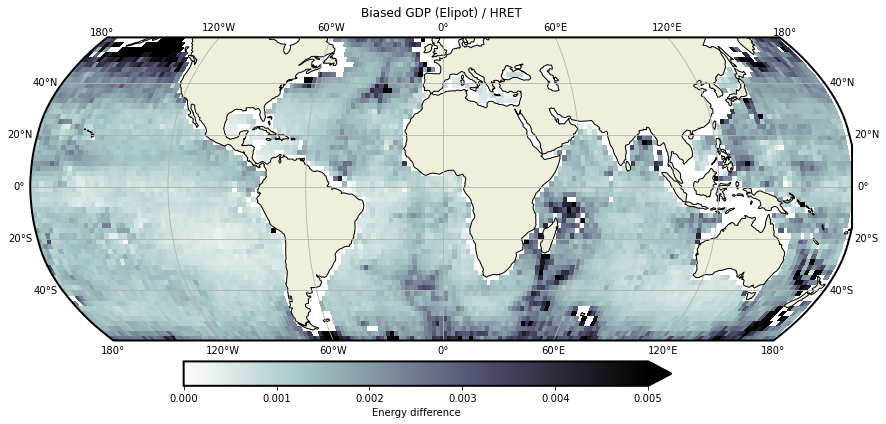

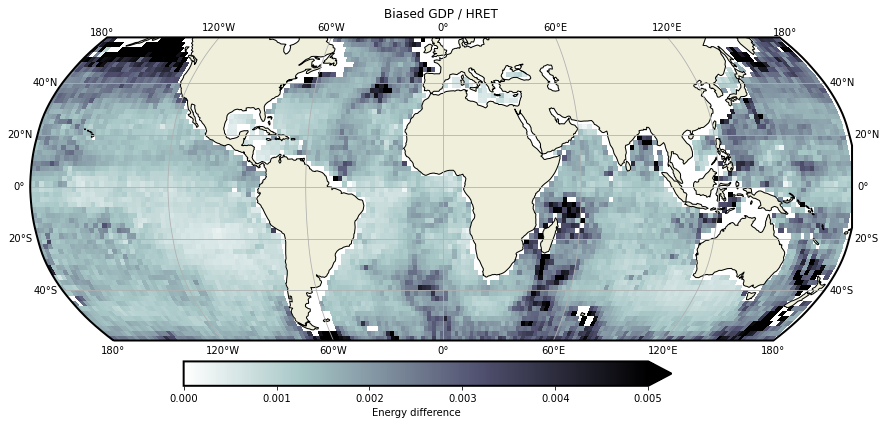

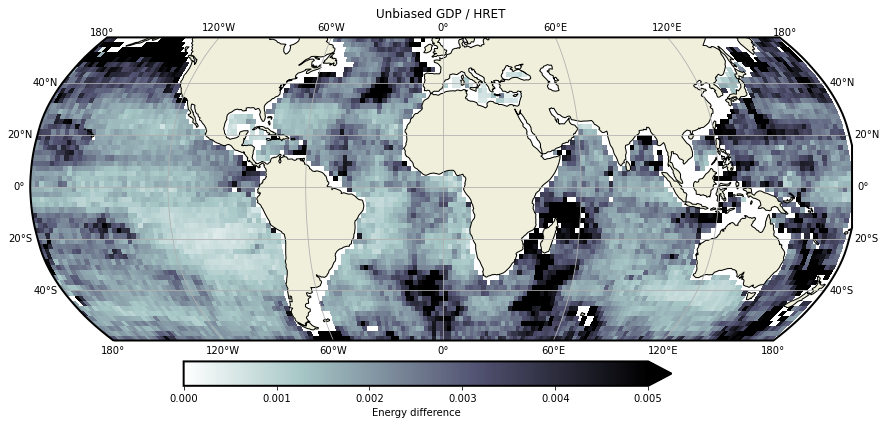

In [134]:
cmap='bone_r'
fig = plt.figure(figsize=(15,6))
kwargs.update({'label': 'Energy difference'})
fig,ax = plot_maps(np.abs(ds_GDP_dl2-ds_hret['energy_total']),lat='lat_bin',colmap=cmap,vlim=(0,5e-3),**kwargs)
ax.set_title('Biased GDP (Elipot) / HRET')
fig.tight_layout()

fig = plt.figure(figsize=(15,6))
kwargs.update({'label': 'Energy difference'})
fig,ax = plot_maps(np.abs(ds_gdp.L_energy-ds_hret['energy_total']),lat='lat_bin',colmap=cmap,vlim=(0,5e-3),**kwargs)
ax.set_title('Biased GDP / HRET')
fig.tight_layout()

fig = plt.figure(figsize=(15,6))
kwargs.update({'label': 'Energy difference'})
fig,ax = plot_maps(np.abs(ds_gdp.E_energy-ds_hret['energy_total']),lat='lat_bin',colmap=cmap,vlim=(0,5e-3),**kwargs)
ax.set_title('Unbiased GDP / HRET')
fig.tight_layout()

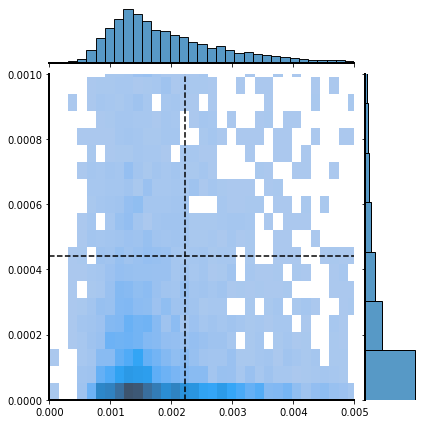

<Figure size 432x288 with 0 Axes>

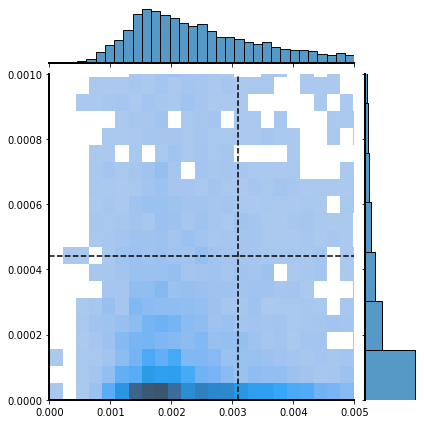

<Figure size 432x288 with 0 Axes>

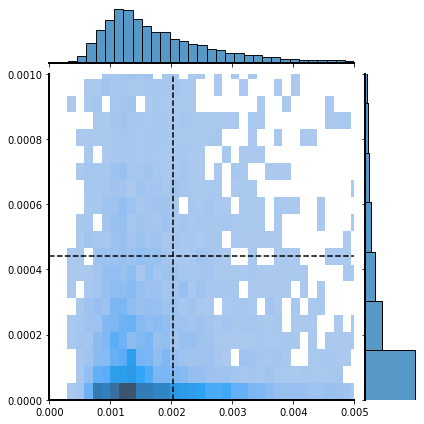

In [97]:
#Biased GDP / HYCOM
plot = sns.jointplot(x=ds_gdp.L_energy.values.flatten(),y=ds_hret['energy_total'].values.flatten()
                   ,xlim=(0,0.005),ylim=(0,0.001),kind='hist',marginal_kws=dict(bins=np.linspace(0,0.015,100))
                    )
plot.ax_joint.axvline(x=ds_gdp.L_energy.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.axhline(y=ds_hret['energy_total'].mean(skipna=True).values,ls='--',c='k')
#plot.ax_joint.plot([0,1],[0,1],c='k')

#Unbiased GDP / HYCOM
plt.figure()
plot = sns.jointplot(x=ds_gdp.E_energy.values.flatten(),y=ds_hret['energy_total'].values.flatten()
                   ,xlim=(0,0.005),ylim=(0,0.001),kind='hist',marginal_kws=dict(bins=np.linspace(0,0.015,100))
                    )
plot.ax_joint.axvline(x=ds_gdp.E_energy.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.axhline(y=ds_hret['energy_total'].mean(skipna=True).values,ls='--',c='k')
#plot.ax_joint.plot([0,1],[0,1],c='k')

#Biased GDP (Elipot) / HYCOM
plt.figure()
plot = sns.jointplot(x=ds_GDP_dl2.values.flatten(),y=ds_hret['energy_total'].values.flatten()
                   ,xlim=(0,0.005),ylim=(0,0.001),kind='hist',marginal_kws=dict(bins=np.linspace(0,0.015,100))
                    )
plot.ax_joint.axvline(x=ds_GDP_dl2.mean(skipna=True).values,ls='--',c='k')
plot.ax_joint.axhline(y=ds_hret['energy_total'].mean(skipna=True).values,ls='--',c='k')
#plot.ax_joint.plot([0,1],[0,1],c='k')

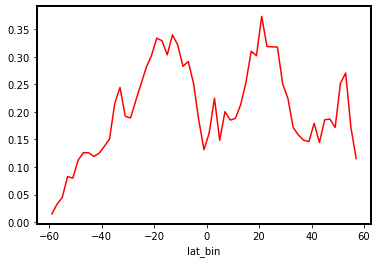

(0.0, 0.01)

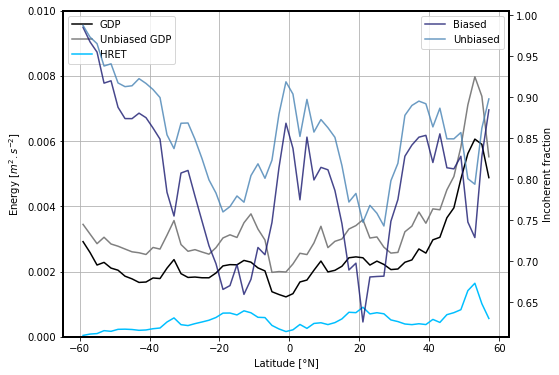

In [82]:
fig,ax = plt.subplots(figsize=(8,6))
(ds_gdp.L_energy).mean('lon_bin').plot(ax=ax,label='GDP',c='k')
#(ds_GDP_dl2).mean('lon_bin').plot(ax=ax,label='GDP (Shane)',c='k',ls='--')
(ds_gdp.E_energy).mean('lon_bin').plot(ax=ax,label='Unbiased GDP',c='grey')
ds_hret['energy_total'].mean('lon_bin').plot(ax=ax,label='HRET',c='deepskyblue')
ax1 = ax.twinx()
(1-ds_hret['energy_total'].mean('lon_bin')/(ds_gdp.L_energy.mean('lon_bin'))
).plot(ax=ax1,label='Biased',c='midnightblue',zorder=-1,alpha=0.8)
(1-ds_hret['energy_total'].mean('lon_bin')/(ds_gdp.E_energy.mean('lon_bin'))
).plot(ax=ax1,label='Unbiased',c='steelblue',zorder=-1,alpha=0.8)

ax.set_ylabel(r'Energy [$m^2.s^{-2}$]');ax.set_xlabel(r'Latitude [°N]')
ax1.set_ylabel(r'Incoherent fraction');ax1.legend(loc=1)
ax.grid();ax.legend(loc=2);ax.set_ylim(0,0.01)
#ax.set_title('Figure 14 (Arbic 2022) + my data')